# 🏪 Kirana Store Sales Forecasting Pipeline

## 7-Day Ahead Sales Prediction using LightGBM, XGBoost & Ensemble Methods

**Dataset:** Kirana Sales Data v2.3 (Oct 30, 2023 - Nov 10, 2025)

**Objective:** Forecast sales (quantity_sold) for next 7 days (Nov 11-17, 2025) for all 50 products

**Models:**
- LightGBM
- XGBoost
- Ensemble (Weighted Average)

**Key Features:**
- Advanced feature engineering (lags, rolling stats, cyclic encoding)
- Festival-aware predictions
- Discount logic integration
- Product-specific patterns
- Category-based elasticity

## 📦 1. Import Libraries and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Date handling
from datetime import datetime, timedelta

# Optimization
from scipy.optimize import minimize

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🚀 LightGBM version: {lgb.__version__}")
print(f"🌲 XGBoost version: {xgb.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 2.2.3
🚀 LightGBM version: 4.6.0
🌲 XGBoost version: 3.1.1


## 📂 2. Load Sales Data

In [2]:
# Load the dataset
df = pd.read_csv('kirana_sales_data_v2.3_production_discount.csv')

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Sort by date and product
df = df.sort_values(['sale_date', 'product_name']).reset_index(drop=True)

print("="*80)
print("📊 DATASET LOADED SUCCESSFULLY")
print("="*80)
print(f"Total Records: {len(df):,}")
print(f"Date Range: {df['sale_date'].min()} to {df['sale_date'].max()}")
print(f"Number of Products: {df['product_name'].nunique()}")
print(f"Number of Days: {df['sale_date'].nunique()}")
print(f"Categories: {df['category'].nunique()} - {df['category'].unique().tolist()}")
print("="*80)

# Display first few rows
df.head(10)

📊 DATASET LOADED SUCCESSFULLY
Total Records: 37,350
Date Range: 2023-10-30 00:00:00 to 2025-11-14 00:00:00
Number of Products: 50
Number of Days: 747
Categories: 5 - ['Staples', 'Dairy', 'Snacks', 'Beverages', 'Personal Care']


,sale_date,product_id,product_name,category,season_affinity,price,cost_price,quantity_sold,discount_percent,final_price,revenue,profit,day_of_week,is_weekend,month,year,is_festival,festival_name
0,2023-10-30,34,Aashirvaad Atta 5kg,Staples,all,250,180,13,0.00,250.00,3250.00,910.00,0,0,10,2023,0,NaN
1,2023-10-30,2,Amul Butter 100g,Dairy,all,60,42,29,2.00,58.80,1705.20,487.20,0,0,10,2023,0,NaN
2,2023-10-30,10,Amul Buttermilk 200ml,Dairy,summer,15,9,16,2.00,14.70,235.20,91.20,0,0,10,2023,0,NaN
3,2023-10-30,4,Amul Cheese Slices 200g,Dairy,all,120,85,15,3.25,116.10,1741.50,466.50,0,0,10,2023,0,NaN
4,2023-10-30,6,Amul Ghee 500ml,Dairy,winter,300,220,9,2.25,293.25,2639.25,659.25,0,0,10,2023,0,NaN
5,2023-10-30,8,Amul Lassi 200ml,Dairy,summer,20,12,25,2.25,19.55,488.75,188.75,0,0,10,2023,0,NaN
6,2023-10-30,1,Amul Milk 1L,Dairy,all,50,35,42,3.25,48.38,2031.75,561.75,0,0,10,2023,0,NaN
7,2023-10-30,28,Bikano Soan Papdi 250g,Snacks,winter,100,70,9,0.00,100.00,900.00,270.00,0,0,10,2023,0,NaN
8,2023-10-30,13,Bisleri Water 1L,Beverages,summer,20,12,23,0.00,20.00,460.00,184.00,0,0,10,2023,0,NaN
9,2023-10-30,32,Britannia Bourbon 120g,Snacks,all,30,20,16,0.00,30.00,480.00,160.00,0,0,10,2023,0,NaN


## 🎯 3. Festival & Discount Configuration (from Data Generation Logic)

In [3]:
# Festival Impact Configuration (same as data generation)
FESTIVAL_IMPACTS = {
    "Makar Sankranti": {"prep_days": 1, "duration_days": 1, "impact": {"Staples": 2.0, "Snacks": 1.8, "Dairy": 1.5}},
    "Republic Day": {"prep_days": 0, "duration_days": 1, "impact": {"Beverages": 1.5, "Snacks": 1.5}},
    "Valentine's Day": {"prep_days": 1, "duration_days": 1, "impact": {"Snacks": 2.0}},
    "Maha Shivratri": {"prep_days": 1, "duration_days": 1, "impact": {"Dairy": 2.0, "Staples": 2.5}},
    "Holi": {"prep_days": 2, "duration_days": 1, "impact": {"Beverages": 3.0, "Personal Care": 2.5, "Snacks": 2.0, "Dairy": 1.8}},
    "Eid ul-Fitr": {"prep_days": 3, "duration_days": 1, "impact": {"Dairy": 3.0, "Staples": 2.5, "Snacks": 3.0, "Beverages": 2.0}},
    "Ram Navami": {"prep_days": 1, "duration_days": 1, "impact": {"Dairy": 2.0, "Snacks": 2.5}},
    "Eid ul-Adha": {"prep_days": 2, "duration_days": 1, "impact": {"Staples": 2.5, "Dairy": 2.5, "Snacks": 2.0}},
    "Independence Day": {"prep_days": 0, "duration_days": 1, "impact": {"Beverages": 1.5, "Snacks": 1.5}},
    "Raksha Bandhan": {"prep_days": 1, "duration_days": 1, "impact": {"Snacks": 3.0, "Dairy": 1.5}},
    "Janmashtami": {"prep_days": 1, "duration_days": 1, "impact": {"Dairy": 2.5, "Snacks": 2.0}},
    "Navratri": {"prep_days": 1, "duration_days": 9, "impact": {"Staples": 4.0, "Dairy": 2.0, "Beverages": 2.0}},
    "Dussehra": {"prep_days": 1, "duration_days": 1, "impact": {"Snacks": 2.5, "Dairy": 1.8, "Beverages": 1.8}},
    "Diwali": {"prep_days": 4, "duration_days": 3, "impact": {"Snacks": 4.0, "Dairy": 3.0, "Staples": 2.5, "Beverages": 2.5, "Personal Care": 1.8}},
    "Bhai Dooj": {"prep_days": 1, "duration_days": 1, "impact": {"Snacks": 2.0}},
    "Christmas": {"prep_days": 3, "duration_days": 1, "impact": {"Beverages": 2.5, "Dairy": 3.0, "Snacks": 2.5}},
    "New Year Eve": {"prep_days": 2, "duration_days": 1, "impact": {"Beverages": 3.0, "Snacks": 2.5}}
}

# Festival Dates for 2025 (for future predictions)
FESTIVAL_DATES_2025 = {
    "Makar Sankranti": "2025-01-14",
    "Republic Day": "2025-01-26",
    "Valentine's Day": "2025-02-14",
    "Maha Shivratri": "2025-02-26",
    "Holi": "2025-03-14",
    "Eid ul-Fitr": "2025-03-31",
    "Ram Navami": "2025-04-06",
    "Eid ul-Adha": "2025-06-07",
    "Independence Day": "2025-08-15",
    "Raksha Bandhan": "2025-08-09",
    "Janmashtami": "2025-08-16",
    "Navratri": "2025-09-22",
    "Dussehra": "2025-10-02",
    "Diwali": "2025-10-20",
    "Bhai Dooj": "2025-10-23",
    "Christmas": "2025-12-25",
    "New Year Eve": "2025-12-31"
}

# Product Master Data (for future feature generation)
PRODUCT_INFO = df.groupby('product_name').agg({
    'category': 'first',
    'season_affinity': 'first',
    'price': 'first',
    'cost_price': 'first'
}).to_dict('index')

print("✅ Festival and product configuration loaded!")
print(f"📅 Festivals configured: {len(FESTIVAL_IMPACTS)}")
print(f"🛍️ Products in catalog: {len(PRODUCT_INFO)}")

✅ Festival and product configuration loaded!
📅 Festivals configured: 17
🛍️ Products in catalog: 50


## 🔧 4. Helper Functions for Festival & Discount Detection

In [4]:
def detect_festival_for_date(date, category):
    """
    Detect if a given date falls in festival period for specific category
    Returns: (is_festival, festival_name, days_to_festival, discount_percent)
    """
    date = pd.to_datetime(date).date()
    year = date.year
    
    # Get festival calendar for year
    if year == 2025:
        festival_calendar = FESTIVAL_DATES_2025
    else:
        festival_calendar = {}
    
    is_festival = 0
    festival_name = ""
    days_to_festival = 999
    
    for fest_name, fest_date_str in festival_calendar.items():
        fest_date = pd.to_datetime(fest_date_str).date()
        fest_info = FESTIVAL_IMPACTS.get(fest_name, {})
        
        prep_days = fest_info.get('prep_days', 0)
        duration_days = fest_info.get('duration_days', 1)
        
        prep_start = fest_date - timedelta(days=prep_days)
        fest_end = fest_date + timedelta(days=duration_days - 1)
        
        # Check if date falls in prep or festival period
        if prep_start <= date <= fest_end:
            # Check if category is impacted
            if category in fest_info.get('impact', {}):
                is_festival = 1
                festival_name = fest_name
                days_to_festival = (fest_date - date).days
                break
    
    return is_festival, festival_name, days_to_festival


def calculate_discount_for_date(date, category):
    """
    Calculate discount percent for a given date and category
    Uses the same logic as data generation
    """
    date = pd.to_datetime(date)
    day = date.date()
    discount = 0.0
    
    # 1. Daily rotating discount (2-3.5%)
    day_of_week = date.weekday()
    daily_category_map = {
        0: "Dairy", 1: "Beverages", 2: "Snacks", 3: "Personal Care",
        4: "Staples", 5: "Snacks", 6: "Beverages"
    }
    if category == daily_category_map.get(day_of_week):
        discount = max(discount, np.random.choice([2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]))
    
    # 2. Flash sales (Every 3rd Wednesday - 12%)
    if day.weekday() == 2:
        week_of_month = (day.day - 1) // 7 + 1
        if week_of_month == 3:
            month_category_map = {
                1: "Beverages", 2: "Snacks", 3: "Personal Care", 4: "Dairy",
                5: "Beverages", 6: "Snacks", 7: "Personal Care", 8: "Dairy",
                9: "Beverages", 10: "Snacks", 11: "Personal Care", 12: "Dairy"
            }
            if category == month_category_map.get(day.month):
                discount = max(discount, 12.0)
    
    # 3. Festival prep discounts (10-15%)
    festival_calendar = FESTIVAL_DATES_2025 if day.year == 2025 else {}
    for fest_name, fest_date_str in festival_calendar.items():
        if fest_name not in {"Diwali", "Christmas", "Navratri"}:
            continue
        fest_date = pd.to_datetime(fest_date_str).date()
        days_before = (fest_date - day).days
        if 1 <= days_before <= 2:
            if category in ["Snacks", "Beverages"]:
                discount = max(discount, 15.0)
            else:
                discount = max(discount, 10.0)
    
    return round(discount, 2)


print("✅ Helper functions defined successfully!")
print("   - detect_festival_for_date()")
print("   - calculate_discount_for_date()")

✅ Helper functions defined successfully!
   - detect_festival_for_date()
   - calculate_discount_for_date()


## 🛠️ 5. Advanced Feature Engineering

In [5]:
def create_features(df):
    """
    Create ADVANCED feature set for improved forecasting accuracy
    """
    df = df.copy()
    
    # ============================================
    # 1. TIME-BASED FEATURES (Enhanced)
    # ============================================
    df['day_of_week'] = df['sale_date'].dt.dayofweek
    df['day_of_month'] = df['sale_date'].dt.day
    df['week_of_year'] = df['sale_date'].dt.isocalendar().week
    df['month'] = df['sale_date'].dt.month
    df['quarter'] = df['sale_date'].dt.quarter
    df['year'] = df['sale_date'].dt.year
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = (df['day_of_month'] <= 7).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 23).astype(int)
    df['days_in_month'] = df['sale_date'].dt.days_in_month
    df['day_of_year'] = df['sale_date'].dt.dayofyear
    
    # NEW: Pay day features (1st, 15th, 30th)
    df['is_payday'] = df['day_of_month'].isin([1, 15, 30]).astype(int)
    df['days_since_month_start'] = df['day_of_month']
    df['days_until_month_end'] = df['days_in_month'] - df['day_of_month']
    
    # Cyclical encoding for month and day_of_week
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # ============================================
    # 2. PRODUCT ENCODING (Enhanced Target Encoding)
    # ============================================
    # Calculate mean sales per product
    product_means = df.groupby('product_name')['quantity_sold'].mean()
    product_std = df.groupby('product_name')['quantity_sold'].std()
    product_median = df.groupby('product_name')['quantity_sold'].median()
    product_max = df.groupby('product_name')['quantity_sold'].max()
    
    df['product_encoded'] = df['product_name'].map(product_means)
    df['product_std'] = df['product_name'].map(product_std).fillna(0)
    df['product_median'] = df['product_name'].map(product_median)
    df['product_max'] = df['product_name'].map(product_max)
    
    # Category encoding
    category_means = df.groupby('category')['quantity_sold'].mean()
    category_std = df.groupby('category')['quantity_sold'].std()
    df['category_encoded'] = df['category'].map(category_means)
    df['category_std'] = df['category'].map(category_std)
    
    # Product-Category interaction
    prod_cat_means = df.groupby(['product_name', 'category'])['quantity_sold'].mean()
    df['product_category_encoded'] = df.apply(lambda x: prod_cat_means.get((x['product_name'], x['category']), x['product_encoded']), axis=1)
    
    # ============================================
    # 3. ENHANCED LAG FEATURES (1, 3, 7, 14, 21, 30 days)
    # ============================================
    for lag in [1, 3, 7, 14, 21, 30]:
        df[f'lag_{lag}'] = df.groupby('product_name')['quantity_sold'].shift(lag)
    
    # NEW: Lag differences (momentum/trend indicators)
    df['lag_diff_7_1'] = df['lag_1'] - df['lag_7']
    df['lag_diff_14_7'] = df['lag_7'] - df['lag_14']
    df['lag_diff_30_14'] = df['lag_14'] - df['lag_30']
    
    # NEW: Percentage changes
    df['lag_pct_change_7'] = (df['lag_1'] - df['lag_7']) / (df['lag_7'] + 1)
    df['lag_pct_change_30'] = (df['lag_7'] - df['lag_30']) / (df['lag_30'] + 1)
    
    # ============================================
    # 4. ENHANCED ROLLING STATISTICS (3, 7, 14, 30-day windows)
    # ============================================
    for window in [3, 7, 14, 30]:
        # Rolling mean
        df[f'rolling_mean_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        # Rolling std
        df[f'rolling_std_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        # Rolling min
        df[f'rolling_min_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).min()
        )
        # Rolling max
        df[f'rolling_max_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
        # NEW: Rolling median
        df[f'rolling_median_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).median()
        )
        # NEW: Rolling quantiles
        df[f'rolling_q25_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).quantile(0.25)
        )
        df[f'rolling_q75_{window}'] = df.groupby('product_name')['quantity_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).quantile(0.75)
        )
    
    # NEW: Coefficient of variation (volatility measure)
    df['cv_7'] = df['rolling_std_7'] / (df['rolling_mean_7'] + 1)
    df['cv_30'] = df['rolling_std_30'] / (df['rolling_mean_30'] + 1)
    
    # ============================================
    # 5. EXPONENTIALLY WEIGHTED MOVING AVERAGE (Enhanced)
    # ============================================
    df['ewm_3'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=3, adjust=False).mean()
    )
    df['ewm_7'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=7, adjust=False).mean()
    )
    df['ewm_14'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=14, adjust=False).mean()
    )
    df['ewm_30'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=30, adjust=False).mean()
    )
    
    # NEW: EWMA Standard deviation
    df['ewm_std_7'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=7, adjust=False).std()
    )
    df['ewm_std_30'] = df.groupby('product_name')['quantity_sold'].transform(
        lambda x: x.ewm(span=30, adjust=False).std()
    )
    
    # ============================================
    # 6. ENHANCED INTERACTION FEATURES
    # ============================================
    df['discount_festival_interaction'] = df['discount_percent'] * df['is_festival']
    df['weekend_festival_interaction'] = df['is_weekend'] * df['is_festival']
    df['discount_weekend_interaction'] = df['discount_percent'] * df['is_weekend']
    df['discount_squared'] = df['discount_percent'] ** 2
    df['discount_weekend_festival'] = df['discount_percent'] * df['is_weekend'] * df['is_festival']
    
    # NEW: Price-related interactions
    df['discount_price_interaction'] = df['discount_percent'] * df['price']
    df['festival_price_interaction'] = df['is_festival'] * df['price']
    
    # ============================================
    # 7. SEASON ENCODING
    # ============================================
    season_map = {'all': 0, 'summer': 1, 'winter': 2, 'monsoon': 3}
    df['season_encoded'] = df['season_affinity'].map(season_map)
    
    # NEW: Season interactions
    df['season_month_interaction'] = df['season_encoded'] * df['month']
    df['season_festival_interaction'] = df['season_encoded'] * df['is_festival']
    
    # ============================================
    # 8. ENHANCED PRICE-RELATED FEATURES
    # ============================================
    df['price_discount_ratio'] = df['final_price'] / df['price']
    df['profit_margin'] = (df['price'] - df['cost_price']) / df['price']
    df['discount_amount'] = df['price'] - df['final_price']
    df['profit_amount'] = df['price'] - df['cost_price']
    df['price_to_cost_ratio'] = df['price'] / df['cost_price']
    
    # NEW: Discount elasticity proxy
    df['discount_impact'] = df['discount_percent'] / (df['price'] + 1)
    
    # ============================================
    # 9. NEW: TREND AND MOMENTUM FEATURES
    # ============================================
    # Week-over-week trend
    df['wow_trend'] = df['lag_7'] - df['lag_14']
    df['wow_trend_pct'] = (df['lag_7'] - df['lag_14']) / (df['lag_14'] + 1)
    
    # Month-over-month trend
    df['mom_trend'] = df['lag_7'] - df['lag_30']
    df['mom_trend_pct'] = (df['lag_7'] - df['lag_30']) / (df['lag_30'] + 1)
    
    # Acceleration (second derivative)
    df['acceleration'] = (df['lag_1'] - df['lag_7']) - (df['lag_7'] - df['lag_14'])
    
    # ============================================
    # 10. NEW: SAME-DAY-OF-WEEK PATTERNS
    # ============================================
    # Average sales on same day of week (last 4 weeks)
    for product in df['product_name'].unique():
        product_mask = df['product_name'] == product
        for dow in range(7):
            dow_mask = product_mask & (df['day_of_week'] == dow)
            df.loc[dow_mask, f'same_dow_mean_4w'] = df.loc[dow_mask, 'quantity_sold'].rolling(4, min_periods=1).mean().shift(1)
    
    # Fill NaN for new feature
    df['same_dow_mean_4w'] = df['same_dow_mean_4w'].fillna(df['rolling_mean_7'])
    
    return df


# Apply feature engineering
print("🔧 Creating ADVANCED features for improved accuracy...")
df_features = create_features(df)

print("✅ Advanced feature engineering complete!")
print(f"   Total features: {len(df_features.columns)}")
print(f"   New features created: {len(df_features.columns) - len(df.columns)}")
print(f"\n📊 Feature count by category:")
print(f"   - Time-based: ~25 features")
print(f"   - Lag features: ~16 features")
print(f"   - Rolling stats: ~35 features")
print(f"   - EWMA: ~6 features")
print(f"   - Interactions: ~15 features")
print(f"   - Trend/Momentum: ~10 features")
print(f"   TOTAL: {len(df_features.columns)} columns")

🔧 Creating ADVANCED features for improved accuracy...
✅ Advanced feature engineering complete!
   Total features: 110
   New features created: 92

📊 Feature count by category:
   - Time-based: ~25 features
   - Lag features: ~16 features
   - Rolling stats: ~35 features
   - EWMA: ~6 features
   - Interactions: ~15 features
   - Trend/Momentum: ~10 features
   TOTAL: 110 columns
✅ Advanced feature engineering complete!
   Total features: 110
   New features created: 92

📊 Feature count by category:
   - Time-based: ~25 features
   - Lag features: ~16 features
   - Rolling stats: ~35 features
   - EWMA: ~6 features
   - Interactions: ~15 features
   - Trend/Momentum: ~10 features
   TOTAL: 110 columns


## 📊 6. Prepare Training Data (Time-Based Split)

In [6]:
# Remove rows with NaN in lag features (first 30 days)
df_clean = df_features.dropna().reset_index(drop=True)

# Define feature columns (exclude target and metadata)
exclude_cols = ['sale_date', 'product_name', 'category', 'season_affinity', 
                'festival_name', 'quantity_sold', 'revenue', 'profit', 'product_id']

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Target variable
target_col = 'quantity_sold'

# Time-based split: Last 30 days as validation
validation_date = df_clean['sale_date'].max() - pd.Timedelta(days=30)

train_data = df_clean[df_clean['sale_date'] < validation_date].copy()
val_data = df_clean[df_clean['sale_date'] >= validation_date].copy()

X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

print("="*80)
print("📊 TRAIN-VALIDATION SPLIT COMPLETE")
print("="*80)
print(f"Training set:")
print(f"  - Records: {len(train_data):,}")
print(f"  - Date range: {train_data['sale_date'].min()} to {train_data['sale_date'].max()}")
print(f"  - Products: {train_data['product_name'].nunique()}")
print()
print(f"Validation set:")
print(f"  - Records: {len(val_data):,}")
print(f"  - Date range: {val_data['sale_date'].min()} to {val_data['sale_date'].max()}")
print(f"  - Products: {val_data['product_name'].nunique()}")
print()
print(f"Features: {len(feature_cols)}")
print("="*80)

# Display feature list
print("\n📋 Features used for modeling:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")
print(f"\n✅ Total: {len(feature_cols)} features")

📊 TRAIN-VALIDATION SPLIT COMPLETE
Training set:
  - Records: 2,499
  - Date range: 2023-12-22 00:00:00 to 2025-09-22 00:00:00
  - Products: 50

Validation set:
  - Records: 661
  - Date range: 2025-09-23 00:00:00 to 2025-10-23 00:00:00
  - Products: 50

Features: 101

📋 Features used for modeling:
   1. price
   2. cost_price
   3. discount_percent
   4. final_price
   5. day_of_week
   6. is_weekend
   7. month
   8. year
   9. is_festival
  10. day_of_month
  11. week_of_year
  12. quarter
  13. is_month_start
  14. is_month_end
  15. days_in_month
  16. day_of_year
  17. is_payday
  18. days_since_month_start
  19. days_until_month_end
  20. month_sin
  21. month_cos
  22. dow_sin
  23. dow_cos
  24. day_of_year_sin
  25. day_of_year_cos
  26. product_encoded
  27. product_std
  28. product_median
  29. product_max
  30. category_encoded
  31. category_std
  32. product_category_encoded
  33. lag_1
  34. lag_3
  35. lag_7
  36. lag_14
  37. lag_21
  38. lag_30
  39. lag_diff_7_1
  4

## 🚀 7. Train LightGBM Model

In [7]:
print("🚀 Training OPTIMIZED LightGBM model...")

# OPTIMIZED LightGBM parameters (tuned for higher accuracy)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,  # Increased from 31
    'learning_rate': 0.03,  # Lower learning rate for better generalization
    'feature_fraction': 0.85,  # Slightly increased
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'max_depth': 8,  # Set explicit depth
    'min_child_samples': 10,  # Reduced to capture more patterns
    'min_child_weight': 0.001,
    'lambda_l1': 0.5,  # Increased regularization
    'lambda_l2': 0.5,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'verbosity': -1,
    'seed': RANDOM_SEED
}

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Train model with more rounds
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=2000,  # Increased from 1000
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),  # Increased patience
        lgb.log_evaluation(period=100)
    ]
)

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Evaluation metrics
def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"📈 {model_name} - Performance Metrics")
    print(f"{'='*60}")
    print(f"MAE  (Mean Absolute Error)    : {mae:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAPE (Mean Absolute % Error)  : {mape:.2f}%")
    print(f"R²   (R-squared Score)        : {r2:.4f}")
    print(f"{'='*60}")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

# Evaluate on validation set
lgb_metrics = evaluate_model(y_val, y_val_pred_lgb, "LightGBM (Optimized)")

print(f"\n✅ LightGBM model trained successfully!")
print(f"   Best iteration: {lgb_model.best_iteration}")
print(f"   Training R²: {r2_score(y_train, y_train_pred_lgb):.4f}")

🚀 Training OPTIMIZED LightGBM model...
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.48717	valid's rmse: 13.43
[100]	train's rmse: 3.48717	valid's rmse: 13.43
[200]	train's rmse: 1.57693	valid's rmse: 12.5053
Early stopping, best iteration is:
[185]	train's rmse: 1.66669	valid's rmse: 12.4734

📈 LightGBM (Optimized) - Performance Metrics
MAE  (Mean Absolute Error)    : 6.0699
RMSE (Root Mean Squared Error): 12.4734
MAPE (Mean Absolute % Error)  : 14.87%
R²   (R-squared Score)        : 0.9231

✅ LightGBM model trained successfully!
   Best iteration: 185
   Training R²: 0.9982
[200]	train's rmse: 1.57693	valid's rmse: 12.5053
Early stopping, best iteration is:
[185]	train's rmse: 1.66669	valid's rmse: 12.4734

📈 LightGBM (Optimized) - Performance Metrics
MAE  (Mean Absolute Error)    : 6.0699
RMSE (Root Mean Squared Error): 12.4734
MAPE (Mean Absolute % Error)  : 14.87%
R²   (R-squared Score)        : 0.9231

✅ LightGBM model trained successfully!
 

## 🌲 8. Train XGBoost Model

In [8]:
print("🌲 Training OPTIMIZED XGBoost model...")

# OPTIMIZED XGBoost parameters (tuned for higher accuracy)
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'max_depth': 8,  # Increased from 6
    'learning_rate': 0.03,  # Lower for better generalization
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'colsample_bylevel': 0.85,
    'min_child_weight': 1,  # Reduced from 3
    'gamma': 0.05,
    'lambda': 2,  # Increased L2 regularization
    'alpha': 0.5,  # L1 regularization
    'max_delta_step': 1,
    'seed': RANDOM_SEED,
    'verbosity': 1,
    'tree_method': 'hist'  # Faster training
}

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model with more rounds
evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=2000,  # Increased from 1000
    evals=evals,
    early_stopping_rounds=100,  # Increased patience
    verbose_eval=100
)

# Predictions
y_train_pred_xgb = xgb_model.predict(dtrain)
y_val_pred_xgb = xgb_model.predict(dval)

# Evaluate
xgb_metrics = evaluate_model(y_val, y_val_pred_xgb, "XGBoost (Optimized)")

print(f"\n✅ XGBoost model trained successfully!")
print(f"   Best iteration: {xgb_model.best_iteration}")
print(f"   Training R²: {r2_score(y_train, y_train_pred_xgb):.4f}")

🌲 Training OPTIMIZED XGBoost model...
[0]	train-rmse:39.15262	eval-rmse:45.00766
[100]	train-rmse:37.06170	eval-rmse:43.14133
[100]	train-rmse:37.06170	eval-rmse:43.14133
[200]	train-rmse:35.06092	eval-rmse:41.36651
[200]	train-rmse:35.06092	eval-rmse:41.36651
[300]	train-rmse:33.14608	eval-rmse:39.67120
[300]	train-rmse:33.14608	eval-rmse:39.67120
[400]	train-rmse:31.32764	eval-rmse:38.08097
[400]	train-rmse:31.32764	eval-rmse:38.08097
[500]	train-rmse:29.61168	eval-rmse:36.58434
[500]	train-rmse:29.61168	eval-rmse:36.58434
[600]	train-rmse:28.00352	eval-rmse:35.19279
[600]	train-rmse:28.00352	eval-rmse:35.19279
[700]	train-rmse:26.51502	eval-rmse:33.93195
[700]	train-rmse:26.51502	eval-rmse:33.93195
[800]	train-rmse:25.12471	eval-rmse:32.77986
[800]	train-rmse:25.12471	eval-rmse:32.77986
[900]	train-rmse:23.85469	eval-rmse:31.72809
[900]	train-rmse:23.85469	eval-rmse:31.72809
[1000]	train-rmse:22.70861	eval-rmse:30.80538
[1000]	train-rmse:22.70861	eval-rmse:30.80538
[1100]	train-rmse

## 🎯 9. Create ADVANCED Ensemble Model (Stacking + Weighted Blending)

## 🐱 8.5. Train CatBoost Model (Additional Power)

In [9]:
print("🐱 Training CatBoost model (additional ensemble member)...")

# CatBoost parameters
catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 10,
    'random_strength': 0.5,
    'bagging_temperature': 0.2,
    'od_type': 'Iter',
    'od_wait': 100,
    'random_seed': RANDOM_SEED,
    'verbose': 100,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
}

# Train CatBoost
catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,
    verbose=100
)

# Predictions
y_train_pred_cat = catboost_model.predict(X_train)
y_val_pred_cat = catboost_model.predict(X_val)

# Evaluate
catboost_metrics = evaluate_model(y_val, y_val_pred_cat, "CatBoost")

print(f"\n✅ CatBoost model trained successfully!")
print(f"   Best iteration: {catboost_model.get_best_iteration()}")
print(f"   Training R²: {r2_score(y_train, y_train_pred_cat):.4f}")

🐱 Training CatBoost model (additional ensemble member)...
0:	learn: 38.3129705	test: 44.3167590	best: 44.3167590 (0)	total: 208ms	remaining: 6m 55s
0:	learn: 38.3129705	test: 44.3167590	best: 44.3167590 (0)	total: 208ms	remaining: 6m 55s
100:	learn: 8.4150003	test: 16.2798322	best: 16.2798322 (100)	total: 2.38s	remaining: 44.8s
100:	learn: 8.4150003	test: 16.2798322	best: 16.2798322 (100)	total: 2.38s	remaining: 44.8s
200:	learn: 4.9666303	test: 13.8487221	best: 13.8487221 (200)	total: 4.55s	remaining: 40.7s
200:	learn: 4.9666303	test: 13.8487221	best: 13.8487221 (200)	total: 4.55s	remaining: 40.7s
300:	learn: 3.6896764	test: 12.9455937	best: 12.9455937 (300)	total: 6.87s	remaining: 38.8s
300:	learn: 3.6896764	test: 12.9455937	best: 12.9455937 (300)	total: 6.87s	remaining: 38.8s
400:	learn: 2.8909039	test: 12.4810110	best: 12.4810110 (400)	total: 9.19s	remaining: 36.6s
400:	learn: 2.8909039	test: 12.4810110	best: 12.4810110 (400)	total: 9.19s	remaining: 36.6s
500:	learn: 2.3842025	test

In [10]:
print("🎯 Creating ADVANCED ensemble models...")
print("="*80)

# ============================================
# METHOD 1: Simple Average
# ============================================
y_val_pred_ensemble_simple = (y_val_pred_lgb + y_val_pred_xgb + y_val_pred_cat) / 3
ensemble_simple_metrics = evaluate_model(y_val, y_val_pred_ensemble_simple, "Ensemble (Simple Average - 3 models)")

# ============================================
# METHOD 2: R²-Weighted Average
# ============================================
total_r2 = lgb_metrics['R2'] + xgb_metrics['R2'] + catboost_metrics['R2']
lgb_weight = lgb_metrics['R2'] / total_r2
xgb_weight = xgb_metrics['R2'] / total_r2
cat_weight = catboost_metrics['R2'] / total_r2

print(f"\n📊 R²-based Optimal Weights:")
print(f"   LightGBM: {lgb_weight:.4f}")
print(f"   XGBoost:  {xgb_weight:.4f}")
print(f"   CatBoost: {cat_weight:.4f}")

y_val_pred_ensemble_weighted = (
    lgb_weight * y_val_pred_lgb + 
    xgb_weight * y_val_pred_xgb + 
    cat_weight * y_val_pred_cat
)
ensemble_weighted_metrics = evaluate_model(y_val, y_val_pred_ensemble_weighted, "Ensemble (R²-Weighted)")

# ============================================
# METHOD 3: Optimized Weighted Average (using scipy.optimize)
# ============================================
print("\n🔍 Finding optimal weights using optimization...")

def ensemble_loss(weights):
    """Objective function to minimize RMSE"""
    weights = np.abs(weights)
    weights = weights / np.sum(weights)  # Normalize
    pred = weights[0] * y_val_pred_lgb + weights[1] * y_val_pred_xgb + weights[2] * y_val_pred_cat
    return np.sqrt(mean_squared_error(y_val, pred))

# Initial guess
initial_weights = np.array([0.33, 0.33, 0.34])

# Optimize
result = minimize(
    ensemble_loss,
    initial_weights,
    method='SLSQP',
    bounds=[(0, 1), (0, 1), (0, 1)],
    constraints={'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1}
)

opt_weights = np.abs(result.x) / np.sum(np.abs(result.x))
print(f"\n🎯 Optimized Weights (RMSE minimization):")
print(f"   LightGBM: {opt_weights[0]:.4f}")
print(f"   XGBoost:  {opt_weights[1]:.4f}")
print(f"   CatBoost: {opt_weights[2]:.4f}")

y_val_pred_ensemble_optimized = (
    opt_weights[0] * y_val_pred_lgb + 
    opt_weights[1] * y_val_pred_xgb + 
    opt_weights[2] * y_val_pred_cat
)
ensemble_optimized_metrics = evaluate_model(y_val, y_val_pred_ensemble_optimized, "Ensemble (Optimized Weights)")

# ============================================
# METHOD 4: Stacking with Ridge Meta-Learner
# ============================================
print("\n🏗️ Training Stacking Ensemble with Ridge meta-learner...")

# Create meta-features from base model predictions
meta_features_train = np.column_stack([
    lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration),
    xgb_model.predict(xgb.DMatrix(X_train)),
    catboost_model.predict(X_train)
])

meta_features_val = np.column_stack([
    y_val_pred_lgb,
    y_val_pred_xgb,
    y_val_pred_cat
])

# Train Ridge meta-model
meta_model = Ridge(alpha=1.0, random_state=RANDOM_SEED)
meta_model.fit(meta_features_train, y_train)

# Predict
y_val_pred_stacking = meta_model.predict(meta_features_val)
ensemble_stacking_metrics = evaluate_model(y_val, y_val_pred_stacking, "Ensemble (Stacking with Ridge)")

print(f"\n📊 Stacking Meta-Model Coefficients:")
print(f"   LightGBM: {meta_model.coef_[0]:.4f}")
print(f"   XGBoost:  {meta_model.coef_[1]:.4f}")
print(f"   CatBoost: {meta_model.coef_[2]:.4f}")
print(f"   Intercept: {meta_model.intercept_:.4f}")

# ============================================
# SELECT BEST ENSEMBLE
# ============================================
ensemble_methods = {
    'Simple Average': (y_val_pred_ensemble_simple, ensemble_simple_metrics),
    'R²-Weighted': (y_val_pred_ensemble_weighted, ensemble_weighted_metrics),
    'Optimized Weights': (y_val_pred_ensemble_optimized, ensemble_optimized_metrics),
    'Stacking': (y_val_pred_stacking, ensemble_stacking_metrics)
}

best_method = max(ensemble_methods.items(), key=lambda x: x[1][1]['R2'])
ensemble_type = best_method[0]
y_val_pred_ensemble = best_method[1][0]
ensemble_metrics = best_method[1][1]

print("\n" + "="*80)
print(f"🏆 BEST ENSEMBLE METHOD: {ensemble_type}")
print(f"   R² Score: {ensemble_metrics['R2']:.4f}")
print(f"   RMSE: {ensemble_metrics['RMSE']:.4f}")
print(f"   MAE: {ensemble_metrics['MAE']:.4f}")
print("="*80)

# Store weights for future predictions
if ensemble_type == 'Optimized Weights':
    final_weights = opt_weights
elif ensemble_type == 'R²-Weighted':
    final_weights = np.array([lgb_weight, xgb_weight, cat_weight])
else:
    final_weights = np.array([1/3, 1/3, 1/3])

🎯 Creating ADVANCED ensemble models...

📈 Ensemble (Simple Average - 3 models) - Performance Metrics
MAE  (Mean Absolute Error)    : 6.9627
RMSE (Root Mean Squared Error): 14.5615
MAPE (Mean Absolute % Error)  : 16.00%
R²   (R-squared Score)        : 0.8951

📊 R²-based Optimal Weights:
   LightGBM: 0.3605
   XGBoost:  0.2752
   CatBoost: 0.3643

📈 Ensemble (R²-Weighted) - Performance Metrics
MAE  (Mean Absolute Error)    : 6.7324
RMSE (Root Mean Squared Error): 13.8990
MAPE (Mean Absolute % Error)  : 15.73%
R²   (R-squared Score)        : 0.9045

🔍 Finding optimal weights using optimization...

🎯 Optimized Weights (RMSE minimization):
   LightGBM: 0.2581
   XGBoost:  0.0000
   CatBoost: 0.7419

📈 Ensemble (Optimized Weights) - Performance Metrics
MAE  (Mean Absolute Error)    : 5.7731
RMSE (Root Mean Squared Error): 11.5509
MAPE (Mean Absolute % Error)  : 14.79%
R²   (R-squared Score)        : 0.9340

🏗️ Training Stacking Ensemble with Ridge meta-learner...

📈 Ensemble (Stacking with R

## 📊 10. Model Comparison & Feature Importance

In [11]:
# Model Comparison Table
comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble (Best)'],
    'MAE': [lgb_metrics['MAE'], xgb_metrics['MAE'], catboost_metrics['MAE'], ensemble_metrics['MAE']],
    'RMSE': [lgb_metrics['RMSE'], xgb_metrics['RMSE'], catboost_metrics['RMSE'], ensemble_metrics['RMSE']],
    'MAPE': [lgb_metrics['MAPE'], xgb_metrics['MAPE'], catboost_metrics['MAPE'], ensemble_metrics['MAPE']],
    'R²': [lgb_metrics['R2'], xgb_metrics['R2'], catboost_metrics['R2'], ensemble_metrics['R2']]
})

print("\n" + "="*80)
print("🏆 MODEL PERFORMANCE COMPARISON (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Determine best model
best_model_idx = comparison_df['R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'R²']
print(f"\n🥇 BEST MODEL: {best_model_name} (R² = {best_r2:.4f})")

# Check if we achieved target
if best_r2 >= 0.85:
    print(f"   ✅ TARGET ACHIEVED! R² ≥ 0.85")
elif best_r2 >= 0.80:
    print(f"   ⚠️ Good performance, close to target (0.85)")
else:
    print(f"   ⚠️ Below target, consider more feature engineering")
    
print("="*80)

# Feature Importance (LightGBM)
importance_lgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(25)

print("\n🔝 TOP 25 FEATURES (LightGBM - by Gain):")
print("="*80)
for idx, row in importance_lgb.iterrows():
    print(f"{row['feature']:45s} : {row['importance']:,.2f}")
print("="*80)

# Feature Importance (XGBoost)
importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.get_score(importance_type='gain').values() if len(xgb_model.get_score(importance_type='gain')) > 0 else [0]*len(feature_cols)
})
if importance_xgb['importance'].sum() > 0:
    importance_xgb = importance_xgb.sort_values('importance', ascending=False).head(10)
    print("\n🔝 TOP 10 FEATURES (XGBoost - by Gain):")
    print("="*80)
    for idx, row in importance_xgb.iterrows():
        print(f"{row['feature']:45s} : {row['importance']:,.2f}")
    print("="*80)


🏆 MODEL PERFORMANCE COMPARISON (Validation Set)
          Model       MAE      RMSE      MAPE       R²
       LightGBM  6.069900 12.473403 14.872837 0.923059
        XGBoost 10.307556 24.442468 19.925038 0.704556
       CatBoost  5.822894 11.666416 15.025543 0.932693
Ensemble (Best)  5.773145 11.550852 14.785280 0.934020

🥇 BEST MODEL: Ensemble (Best) (R² = 0.9340)
   ✅ TARGET ACHIEVED! R² ≥ 0.85

🔝 TOP 25 FEATURES (LightGBM - by Gain):
ewm_3                                         : 39,810,744.08
rolling_max_3                                 : 5,526,993.06
lag_1                                         : 1,897,306.67
ewm_7                                         : 1,564,255.59
ewm_std_7                                     : 1,273,417.93
rolling_q75_3                                 : 667,506.48
lag_3                                         : 433,335.32
rolling_std_3                                 : 307,868.16
lag_diff_7_1                                  : 305,967.21
rolling_max_7   

ValueError: All arrays must be of the same length

In [21]:
%run backend/ml_models/save_trained_models.py

💾 SAVING TRAINED MODELS

1. Saving LightGBM model...

❌ ERROR: name 'lgb_model' is not defined

⚠️ Make sure you have run all cells in the notebook first!
   Required variables: lgb_model, xgb_model, catboost_model, ensemble_type, final_weights, meta_model, feature_cols


## 🔮 11. Generate Future 7-Day Features (Nov 11-17, 2025)

In [12]:
def generate_future_features(last_date, num_days=7):
    """
    Generate future dates with all features needed for prediction
    """
    # Generate future dates
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=num_days,
        freq='D'
    )
    
    # Create future dataframe for all products
    future_records = []
    
    for product_name, product_info in PRODUCT_INFO.items():
        category = product_info['category']
        season_affinity = product_info['season_affinity']
        price = product_info['price']
        cost_price = product_info['cost_price']
        
        for date in future_dates:
            # Detect festival
            is_festival, festival_name, days_to_fest = detect_festival_for_date(date, category)
            
            # Calculate discount
            discount_percent = calculate_discount_for_date(date, category)
            
            # Calculate final price
            final_price = price * (1 - discount_percent / 100.0)
            final_price = max(cost_price * 1.05, final_price)
            
            # Basic features
            record = {
                'sale_date': date,
                'product_name': product_name,
                'category': category,
                'season_affinity': season_affinity,
                'price': price,
                'cost_price': cost_price,
                'discount_percent': discount_percent,
                'final_price': final_price,
                'is_festival': is_festival,
                'festival_name': festival_name if festival_name else "",
                'is_weekend': 1 if date.weekday() >= 5 else 0,
                'day_of_week': date.weekday(),
                'month': date.month,
                'year': date.year
            }
            
            future_records.append(record)
    
    future_df = pd.DataFrame(future_records)
    return future_df


# Generate future dates
last_date = df_features['sale_date'].max()
future_df = generate_future_features(last_date, num_days=7)

print("="*80)
print("🔮 FUTURE 7-DAY FEATURES GENERATED")
print("="*80)
print(f"Date Range: {future_df['sale_date'].min()} to {future_df['sale_date'].max()}")
print(f"Total Records: {len(future_df):,} ({len(future_df)//7} products × 7 days)")
print(f"Products: {future_df['product_name'].nunique()}")
print("="*80)

# Display sample
print("\n📋 Sample future records:")
future_df.head(10)

🔮 FUTURE 7-DAY FEATURES GENERATED
Date Range: 2025-11-15 00:00:00 to 2025-11-21 00:00:00
Total Records: 350 (50 products × 7 days)
Products: 50

📋 Sample future records:


,sale_date,product_name,category,season_affinity,price,cost_price,discount_percent,final_price,is_festival,festival_name,is_weekend,day_of_week,month,year
0,2025-11-15,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,1,5,11,2025
1,2025-11-16,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,1,6,11,2025
2,2025-11-17,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,0,0,11,2025
3,2025-11-18,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,0,1,11,2025
4,2025-11-19,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,0,2,11,2025
5,2025-11-20,Aashirvaad Atta 5kg,Staples,all,250,180,0.00,250.00,0,,0,3,11,2025
6,2025-11-21,Aashirvaad Atta 5kg,Staples,all,250,180,3.50,241.25,0,,0,4,11,2025
7,2025-11-15,Amul Butter 100g,Dairy,all,60,42,0.00,60.00,0,,1,5,11,2025
8,2025-11-16,Amul Butter 100g,Dairy,all,60,42,0.00,60.00,0,,1,6,11,2025
9,2025-11-17,Amul Butter 100g,Dairy,all,60,42,2.75,58.35,0,,0,0,11,2025


## 🔧 12. Prepare Future Features with Lag & Rolling Stats

In [13]:
def prepare_future_features_with_lags(future_df, historical_df):
    """
    Add ALL lag, rolling, and advanced features to future dataframe using historical data
    """
    future_df = future_df.copy()
    historical_df = historical_df.copy()
    
    # For each product, get the most recent feature values
    for product in future_df['product_name'].unique():
        # Get historical data for this product
        hist_product = historical_df[historical_df['product_name'] == product].tail(60)
        
        if len(hist_product) == 0:
            continue
        
        # Get future records for this product
        future_product_mask = future_df['product_name'] == product
        
        # ============================================
        # LAG FEATURES
        # ============================================
        for lag in [1, 3, 7, 14, 21, 30]:
            if len(hist_product) >= lag:
                lag_value = hist_product.iloc[-lag]['quantity_sold']
            else:
                lag_value = hist_product['quantity_sold'].mean()
            future_df.loc[future_product_mask, f'lag_{lag}'] = lag_value
        
        # Lag differences
        future_df.loc[future_product_mask, 'lag_diff_7_1'] = (
            future_df.loc[future_product_mask, 'lag_1'].iloc[0] - 
            future_df.loc[future_product_mask, 'lag_7'].iloc[0]
        )
        future_df.loc[future_product_mask, 'lag_diff_14_7'] = (
            future_df.loc[future_product_mask, 'lag_7'].iloc[0] - 
            future_df.loc[future_product_mask, 'lag_14'].iloc[0]
        )
        future_df.loc[future_product_mask, 'lag_diff_30_14'] = (
            future_df.loc[future_product_mask, 'lag_14'].iloc[0] - 
            future_df.loc[future_product_mask, 'lag_30'].iloc[0]
        )
        
        # Percentage changes
        lag_7_val = future_df.loc[future_product_mask, 'lag_7'].iloc[0]
        lag_30_val = future_df.loc[future_product_mask, 'lag_30'].iloc[0]
        future_df.loc[future_product_mask, 'lag_pct_change_7'] = (
            (future_df.loc[future_product_mask, 'lag_1'].iloc[0] - lag_7_val) / (lag_7_val + 1)
        )
        future_df.loc[future_product_mask, 'lag_pct_change_30'] = (
            (lag_7_val - lag_30_val) / (lag_30_val + 1)
        )
        
        # ============================================
        # ROLLING STATISTICS
        # ============================================
        for window in [3, 7, 14, 30]:
            recent_sales = hist_product.tail(window)['quantity_sold']
            future_df.loc[future_product_mask, f'rolling_mean_{window}'] = recent_sales.mean()
            future_df.loc[future_product_mask, f'rolling_std_{window}'] = recent_sales.std() if len(recent_sales) > 1 else 0
            future_df.loc[future_product_mask, f'rolling_min_{window}'] = recent_sales.min()
            future_df.loc[future_product_mask, f'rolling_max_{window}'] = recent_sales.max()
            future_df.loc[future_product_mask, f'rolling_median_{window}'] = recent_sales.median()
            future_df.loc[future_product_mask, f'rolling_q25_{window}'] = recent_sales.quantile(0.25)
            future_df.loc[future_product_mask, f'rolling_q75_{window}'] = recent_sales.quantile(0.75)
        
        # Coefficient of variation
        rolling_mean_7 = future_df.loc[future_product_mask, 'rolling_mean_7'].iloc[0]
        rolling_std_7 = future_df.loc[future_product_mask, 'rolling_std_7'].iloc[0]
        rolling_mean_30 = future_df.loc[future_product_mask, 'rolling_mean_30'].iloc[0]
        rolling_std_30 = future_df.loc[future_product_mask, 'rolling_std_30'].iloc[0]
        
        future_df.loc[future_product_mask, 'cv_7'] = rolling_std_7 / (rolling_mean_7 + 1)
        future_df.loc[future_product_mask, 'cv_30'] = rolling_std_30 / (rolling_mean_30 + 1)
        
        # ============================================
        # EWMA FEATURES
        # ============================================
        future_df.loc[future_product_mask, 'ewm_3'] = hist_product['quantity_sold'].ewm(span=3, adjust=False).mean().iloc[-1]
        future_df.loc[future_product_mask, 'ewm_7'] = hist_product['quantity_sold'].ewm(span=7, adjust=False).mean().iloc[-1]
        future_df.loc[future_product_mask, 'ewm_14'] = hist_product['quantity_sold'].ewm(span=14, adjust=False).mean().iloc[-1]
        future_df.loc[future_product_mask, 'ewm_30'] = hist_product['quantity_sold'].ewm(span=30, adjust=False).mean().iloc[-1]
        future_df.loc[future_product_mask, 'ewm_std_7'] = hist_product['quantity_sold'].ewm(span=7, adjust=False).std().iloc[-1]
        future_df.loc[future_product_mask, 'ewm_std_30'] = hist_product['quantity_sold'].ewm(span=30, adjust=False).std().iloc[-1]
        
        # ============================================
        # PRODUCT ENCODING
        # ============================================
        future_df.loc[future_product_mask, 'product_encoded'] = hist_product['quantity_sold'].mean()
        future_df.loc[future_product_mask, 'product_std'] = hist_product['quantity_sold'].std()
        future_df.loc[future_product_mask, 'product_median'] = hist_product['quantity_sold'].median()
        future_df.loc[future_product_mask, 'product_max'] = hist_product['quantity_sold'].max()
        
        # ============================================
        # TREND AND MOMENTUM
        # ============================================
        lag_1 = future_df.loc[future_product_mask, 'lag_1'].iloc[0]
        lag_7 = future_df.loc[future_product_mask, 'lag_7'].iloc[0]
        lag_14 = future_df.loc[future_product_mask, 'lag_14'].iloc[0]
        lag_30 = future_df.loc[future_product_mask, 'lag_30'].iloc[0]
        
        future_df.loc[future_product_mask, 'wow_trend'] = lag_7 - lag_14
        future_df.loc[future_product_mask, 'wow_trend_pct'] = (lag_7 - lag_14) / (lag_14 + 1)
        future_df.loc[future_product_mask, 'mom_trend'] = lag_7 - lag_30
        future_df.loc[future_product_mask, 'mom_trend_pct'] = (lag_7 - lag_30) / (lag_30 + 1)
        future_df.loc[future_product_mask, 'acceleration'] = (lag_1 - lag_7) - (lag_7 - lag_14)
        
        # Same day of week mean
        future_df.loc[future_product_mask, 'same_dow_mean_4w'] = rolling_mean_7  # Approximation
    
    # ============================================
    # CATEGORY ENCODING
    # ============================================
    category_means = historical_df.groupby('category')['quantity_sold'].mean()
    category_std = historical_df.groupby('category')['quantity_sold'].std()
    future_df['category_encoded'] = future_df['category'].map(category_means)
    future_df['category_std'] = future_df['category'].map(category_std)
    
    # Product-category interaction
    prod_cat_means = historical_df.groupby(['product_name', 'category'])['quantity_sold'].mean()
    future_df['product_category_encoded'] = future_df.apply(
        lambda x: prod_cat_means.get((x['product_name'], x['category']), x['product_encoded']), 
        axis=1
    )
    
    # ============================================
    # TIME-BASED FEATURES
    # ============================================
    future_df['day_of_month'] = future_df['sale_date'].dt.day
    future_df['week_of_year'] = future_df['sale_date'].dt.isocalendar().week
    future_df['quarter'] = future_df['sale_date'].dt.quarter
    future_df['is_month_start'] = (future_df['day_of_month'] <= 7).astype(int)
    future_df['is_month_end'] = (future_df['day_of_month'] >= 23).astype(int)
    future_df['days_in_month'] = future_df['sale_date'].dt.days_in_month
    future_df['day_of_year'] = future_df['sale_date'].dt.dayofyear
    
    # Payday features
    future_df['is_payday'] = future_df['day_of_month'].isin([1, 15, 30]).astype(int)
    future_df['days_since_month_start'] = future_df['day_of_month']
    future_df['days_until_month_end'] = future_df['days_in_month'] - future_df['day_of_month']
    
    # Cyclical encoding
    future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
    future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
    future_df['dow_sin'] = np.sin(2 * np.pi * future_df['day_of_week'] / 7)
    future_df['dow_cos'] = np.cos(2 * np.pi * future_df['day_of_week'] / 7)
    future_df['day_of_year_sin'] = np.sin(2 * np.pi * future_df['day_of_year'] / 365)
    future_df['day_of_year_cos'] = np.cos(2 * np.pi * future_df['day_of_year'] / 365)
    
    # ============================================
    # INTERACTION FEATURES
    # ============================================
    future_df['discount_festival_interaction'] = future_df['discount_percent'] * future_df['is_festival']
    future_df['weekend_festival_interaction'] = future_df['is_weekend'] * future_df['is_festival']
    future_df['discount_weekend_interaction'] = future_df['discount_percent'] * future_df['is_weekend']
    future_df['discount_squared'] = future_df['discount_percent'] ** 2
    future_df['discount_weekend_festival'] = future_df['discount_percent'] * future_df['is_weekend'] * future_df['is_festival']
    future_df['discount_price_interaction'] = future_df['discount_percent'] * future_df['price']
    future_df['festival_price_interaction'] = future_df['is_festival'] * future_df['price']
    
    # ============================================
    # SEASON ENCODING
    # ============================================
    season_map = {'all': 0, 'summer': 1, 'winter': 2, 'monsoon': 3}
    future_df['season_encoded'] = future_df['season_affinity'].map(season_map)
    future_df['season_month_interaction'] = future_df['season_encoded'] * future_df['month']
    future_df['season_festival_interaction'] = future_df['season_encoded'] * future_df['is_festival']
    
    # ============================================
    # PRICE FEATURES
    # ============================================
    future_df['price_discount_ratio'] = future_df['final_price'] / future_df['price']
    future_df['profit_margin'] = (future_df['price'] - future_df['cost_price']) / future_df['price']
    future_df['discount_amount'] = future_df['price'] - future_df['final_price']
    future_df['profit_amount'] = future_df['price'] - future_df['cost_price']
    future_df['price_to_cost_ratio'] = future_df['price'] / future_df['cost_price']
    future_df['discount_impact'] = future_df['discount_percent'] / (future_df['price'] + 1)
    
    return future_df


# Prepare future features with ALL advanced features
print("🔧 Preparing future features with ALL advanced features...")
future_df_features = prepare_future_features_with_lags(future_df, df_features)

print("✅ Future features prepared with ALL lag, rolling, and advanced statistics!")
print(f"   Features: {len(future_df_features.columns)}")
print(f"   Records: {len(future_df_features):,}")

# Check for missing features
missing_cols = set(feature_cols) - set(future_df_features.columns)
if missing_cols:
    print(f"\n⚠️ Missing features: {missing_cols}")
    print("   Filling with zeros...")
    for col in missing_cols:
        future_df_features[col] = 0
else:
    print(f"\n✅ All {len(feature_cols)} required features present!")

# Fill any remaining NaN values
future_df_features = future_df_features.fillna(0)

future_df_features.head()

🔧 Preparing future features with ALL advanced features...
✅ Future features prepared with ALL lag, rolling, and advanced statistics!
   Features: 106
   Records: 350

✅ All 101 required features present!
✅ Future features prepared with ALL lag, rolling, and advanced statistics!
   Features: 106
   Records: 350

✅ All 101 required features present!


,sale_date,product_name,category,season_affinity,price,cost_price,discount_percent,final_price,is_festival,festival_name,...,festival_price_interaction,season_encoded,season_month_interaction,season_festival_interaction,price_discount_ratio,profit_margin,discount_amount,profit_amount,price_to_cost_ratio,discount_impact
0,2025-11-15,Aashirvaad Atta 5kg,Staples,all,250,180,0.0,250.0,0,,...,0,0,0,0,1.0,0.28,0.0,70,1.388889,0.0
1,2025-11-16,Aashirvaad Atta 5kg,Staples,all,250,180,0.0,250.0,0,,...,0,0,0,0,1.0,0.28,0.0,70,1.388889,0.0
2,2025-11-17,Aashirvaad Atta 5kg,Staples,all,250,180,0.0,250.0,0,,...,0,0,0,0,1.0,0.28,0.0,70,1.388889,0.0
3,2025-11-18,Aashirvaad Atta 5kg,Staples,all,250,180,0.0,250.0,0,,...,0,0,0,0,1.0,0.28,0.0,70,1.388889,0.0
4,2025-11-19,Aashirvaad Atta 5kg,Staples,all,250,180,0.0,250.0,0,,...,0,0,0,0,1.0,0.28,0.0,70,1.388889,0.0


## 🎯 13. Generate 7-Day Forecasts (All Models)

In [14]:
# Prepare feature matrix for prediction
X_future = future_df_features[feature_cols].fillna(0)

print("🔮 Generating predictions for next 7 days with ALL models...")
print("="*80)

# LightGBM predictions
pred_lgb = lgb_model.predict(X_future, num_iteration=lgb_model.best_iteration)
pred_lgb = np.maximum(pred_lgb, 0)  # No negative sales

# XGBoost predictions
dfuture = xgb.DMatrix(X_future)
pred_xgb = xgb_model.predict(dfuture)
pred_xgb = np.maximum(pred_xgb, 0)

# CatBoost predictions
pred_cat = catboost_model.predict(X_future)
pred_cat = np.maximum(pred_cat, 0)

# Ensemble predictions based on best method
if ensemble_type == 'Stacking':
    # Use stacking meta-model
    meta_features_future = np.column_stack([pred_lgb, pred_xgb, pred_cat])
    pred_ensemble = meta_model.predict(meta_features_future)
    pred_ensemble = np.maximum(pred_ensemble, 0)
else:
    # Use weighted average
    pred_ensemble = (
        final_weights[0] * pred_lgb + 
        final_weights[1] * pred_xgb + 
        final_weights[2] * pred_cat
    )
    pred_ensemble = np.maximum(pred_ensemble, 0)

# Add predictions to future dataframe
future_df_features['predicted_quantity_lgb'] = pred_lgb
future_df_features['predicted_quantity_xgb'] = pred_xgb
future_df_features['predicted_quantity_catboost'] = pred_cat
future_df_features['predicted_quantity_ensemble'] = pred_ensemble

# Round to integers (quantity must be whole numbers)
future_df_features['predicted_quantity_lgb'] = future_df_features['predicted_quantity_lgb'].round().astype(int)
future_df_features['predicted_quantity_xgb'] = future_df_features['predicted_quantity_xgb'].round().astype(int)
future_df_features['predicted_quantity_catboost'] = future_df_features['predicted_quantity_catboost'].round().astype(int)
future_df_features['predicted_quantity_ensemble'] = future_df_features['predicted_quantity_ensemble'].round().astype(int)

# Calculate forecasted revenue (using ensemble predictions)
future_df_features['forecasted_revenue'] = (
    future_df_features['predicted_quantity_ensemble'] * future_df_features['final_price']
)

print("✅ Predictions generated successfully!")
print("="*80)

# Summary statistics
print("\n📊 FORECAST SUMMARY (All Models):")
print("="*80)
for model_name, col in [('LightGBM', 'predicted_quantity_lgb'), 
                         ('XGBoost', 'predicted_quantity_xgb'),
                         ('CatBoost', 'predicted_quantity_catboost'),
                         (f'Ensemble ({ensemble_type})', 'predicted_quantity_ensemble')]:
    total = future_df_features[col].sum()
    avg = future_df_features[col].mean()
    revenue = (future_df_features[col] * future_df_features['final_price']).sum()
    print(f"{model_name:30s} - Total: {total:6,} units | Avg/day: {avg:6.2f} | Revenue: ₹{revenue:,.2f}")

print("="*80)

# Display sample predictions
print("\n📋 Sample Forecasts (First 10 records):")
forecast_display = future_df_features[[
    'sale_date', 'product_name', 'category', 'is_festival', 'discount_percent',
    'predicted_quantity_lgb', 'predicted_quantity_xgb', 'predicted_quantity_catboost',
    'predicted_quantity_ensemble', 'final_price', 'forecasted_revenue'
]].head(10)

forecast_display

🔮 Generating predictions for next 7 days with ALL models...
✅ Predictions generated successfully!

📊 FORECAST SUMMARY (All Models):
LightGBM                       - Total:  8,590 units | Avg/day:  24.54 | Revenue: ₹627,374.62
XGBoost                        - Total:  9,109 units | Avg/day:  26.03 | Revenue: ₹660,398.01
CatBoost                       - Total:  8,413 units | Avg/day:  24.04 | Revenue: ₹616,036.51
Ensemble (Optimized Weights)   - Total:  8,452 units | Avg/day:  24.15 | Revenue: ₹618,019.88

📋 Sample Forecasts (First 10 records):


,sale_date,product_name,category,is_festival,discount_percent,predicted_quantity_lgb,predicted_quantity_xgb,predicted_quantity_catboost,predicted_quantity_ensemble,final_price,forecasted_revenue
0,2025-11-15,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,27,27,250.00,6750.0
1,2025-11-16,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,27,27,250.00,6750.0
2,2025-11-17,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,27,27,250.00,6750.0
3,2025-11-18,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,26,26,250.00,6500.0
4,2025-11-19,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,26,26,250.00,6500.0
5,2025-11-20,Aashirvaad Atta 5kg,Staples,0,0.00,27,27,27,27,250.00,6750.0
6,2025-11-21,Aashirvaad Atta 5kg,Staples,0,3.50,27,27,29,28,241.25,6755.0
7,2025-11-15,Amul Butter 100g,Dairy,0,0.00,29,31,29,29,60.00,1740.0
8,2025-11-16,Amul Butter 100g,Dairy,0,0.00,29,31,29,29,60.00,1740.0
9,2025-11-17,Amul Butter 100g,Dairy,0,2.75,29,31,28,28,58.35,1633.8


## 📈 14. Forecast Analysis & Export

In [15]:
# Category-wise forecast summary
category_forecast = future_df_features.groupby('category').agg({
    'predicted_quantity_ensemble': 'sum',
    'forecasted_revenue': 'sum'
}).sort_values('forecasted_revenue', ascending=False)

print("="*80)
print("📊 CATEGORY-WISE 7-DAY FORECAST")
print("="*80)
print(f"{'Category':<20} {'Total Units':>15} {'Total Revenue':>20}")
print("-"*80)
for cat, row in category_forecast.iterrows():
    print(f"{cat:<20} {int(row['predicted_quantity_ensemble']):>15,} ₹{row['forecasted_revenue']:>19,.2f}")
print("="*80)
print(f"{'TOTAL':<20} {int(category_forecast['predicted_quantity_ensemble'].sum()):>15,} ₹{category_forecast['forecasted_revenue'].sum():>19,.2f}")
print("="*80)

# Day-wise forecast
day_forecast = future_df_features.groupby('sale_date').agg({
    'predicted_quantity_ensemble': 'sum',
    'forecasted_revenue': 'sum'
})

print("\n📅 DAY-WISE FORECAST:")
print("="*80)
for date, row in day_forecast.iterrows():
    day_name = date.strftime('%A')
    print(f"{date.strftime('%Y-%m-%d')} ({day_name:9s}) - Units: {int(row['predicted_quantity_ensemble']):5,} | Revenue: ₹{row['forecasted_revenue']:>12,.2f}")
print("="*80)

# Top 10 products by predicted sales
top_products_forecast = future_df_features.groupby('product_name').agg({
    'predicted_quantity_ensemble': 'sum',
    'forecasted_revenue': 'sum',
    'category': 'first'
}).sort_values('predicted_quantity_ensemble', ascending=False).head(10)

print("\n🏆 TOP 10 PRODUCTS (7-Day Total Sales):")
print("="*80)
for idx, (product, row) in enumerate(top_products_forecast.iterrows(), 1):
    print(f"{idx:2d}. {product:45s} [{row['category']:15s}] : {int(row['predicted_quantity_ensemble']):4,} units | ₹{row['forecasted_revenue']:>10,.2f}")
print("="*80)

# Export forecast to CSV
forecast_export = future_df_features[[
    'sale_date', 'product_name', 'category', 'season_affinity',
    'price', 'cost_price', 'discount_percent', 'final_price',
    'is_festival', 'festival_name', 'is_weekend',
    'predicted_quantity_lgb', 'predicted_quantity_xgb', 'predicted_quantity_catboost',
    'predicted_quantity_ensemble', 'forecasted_revenue'
]]

forecast_filename = f"kirana_7day_forecast_IMPROVED_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
forecast_export.to_csv(forecast_filename, index=False)

print(f"\n✅ Forecast exported to: {forecast_filename}")
print(f"   Records: {len(forecast_export):,}")
print(f"   Date Range: {forecast_export['sale_date'].min()} to {forecast_export['sale_date'].max()}")
print(f"   Models included: LightGBM, XGBoost, CatBoost, {ensemble_type} Ensemble")

📊 CATEGORY-WISE 7-DAY FORECAST
Category                 Total Units        Total Revenue
--------------------------------------------------------------------------------
Staples                        1,058 ₹         164,807.34
Beverages                      1,817 ₹         129,875.15
Dairy                          2,212 ₹         128,868.62
Snacks                         2,654 ₹          97,483.45
Personal Care                    711 ₹          96,985.32
TOTAL                          8,452 ₹         618,019.88

📅 DAY-WISE FORECAST:
2025-11-15 (Saturday ) - Units: 1,226 | Revenue: ₹   90,185.52
2025-11-16 (Sunday   ) - Units: 1,225 | Revenue: ₹   90,331.30
2025-11-17 (Monday   ) - Units: 1,181 | Revenue: ₹   85,970.62
2025-11-18 (Tuesday  ) - Units: 1,176 | Revenue: ₹   85,636.85
2025-11-19 (Wednesday) - Units: 1,190 | Revenue: ₹   85,367.32
2025-11-20 (Thursday ) - Units: 1,210 | Revenue: ₹   88,894.93
2025-11-21 (Friday   ) - Units: 1,244 | Revenue: ₹   91,633.34

🏆 TOP 10 PRODUCTS 

## 📊 15. Visualization: Validation Performance

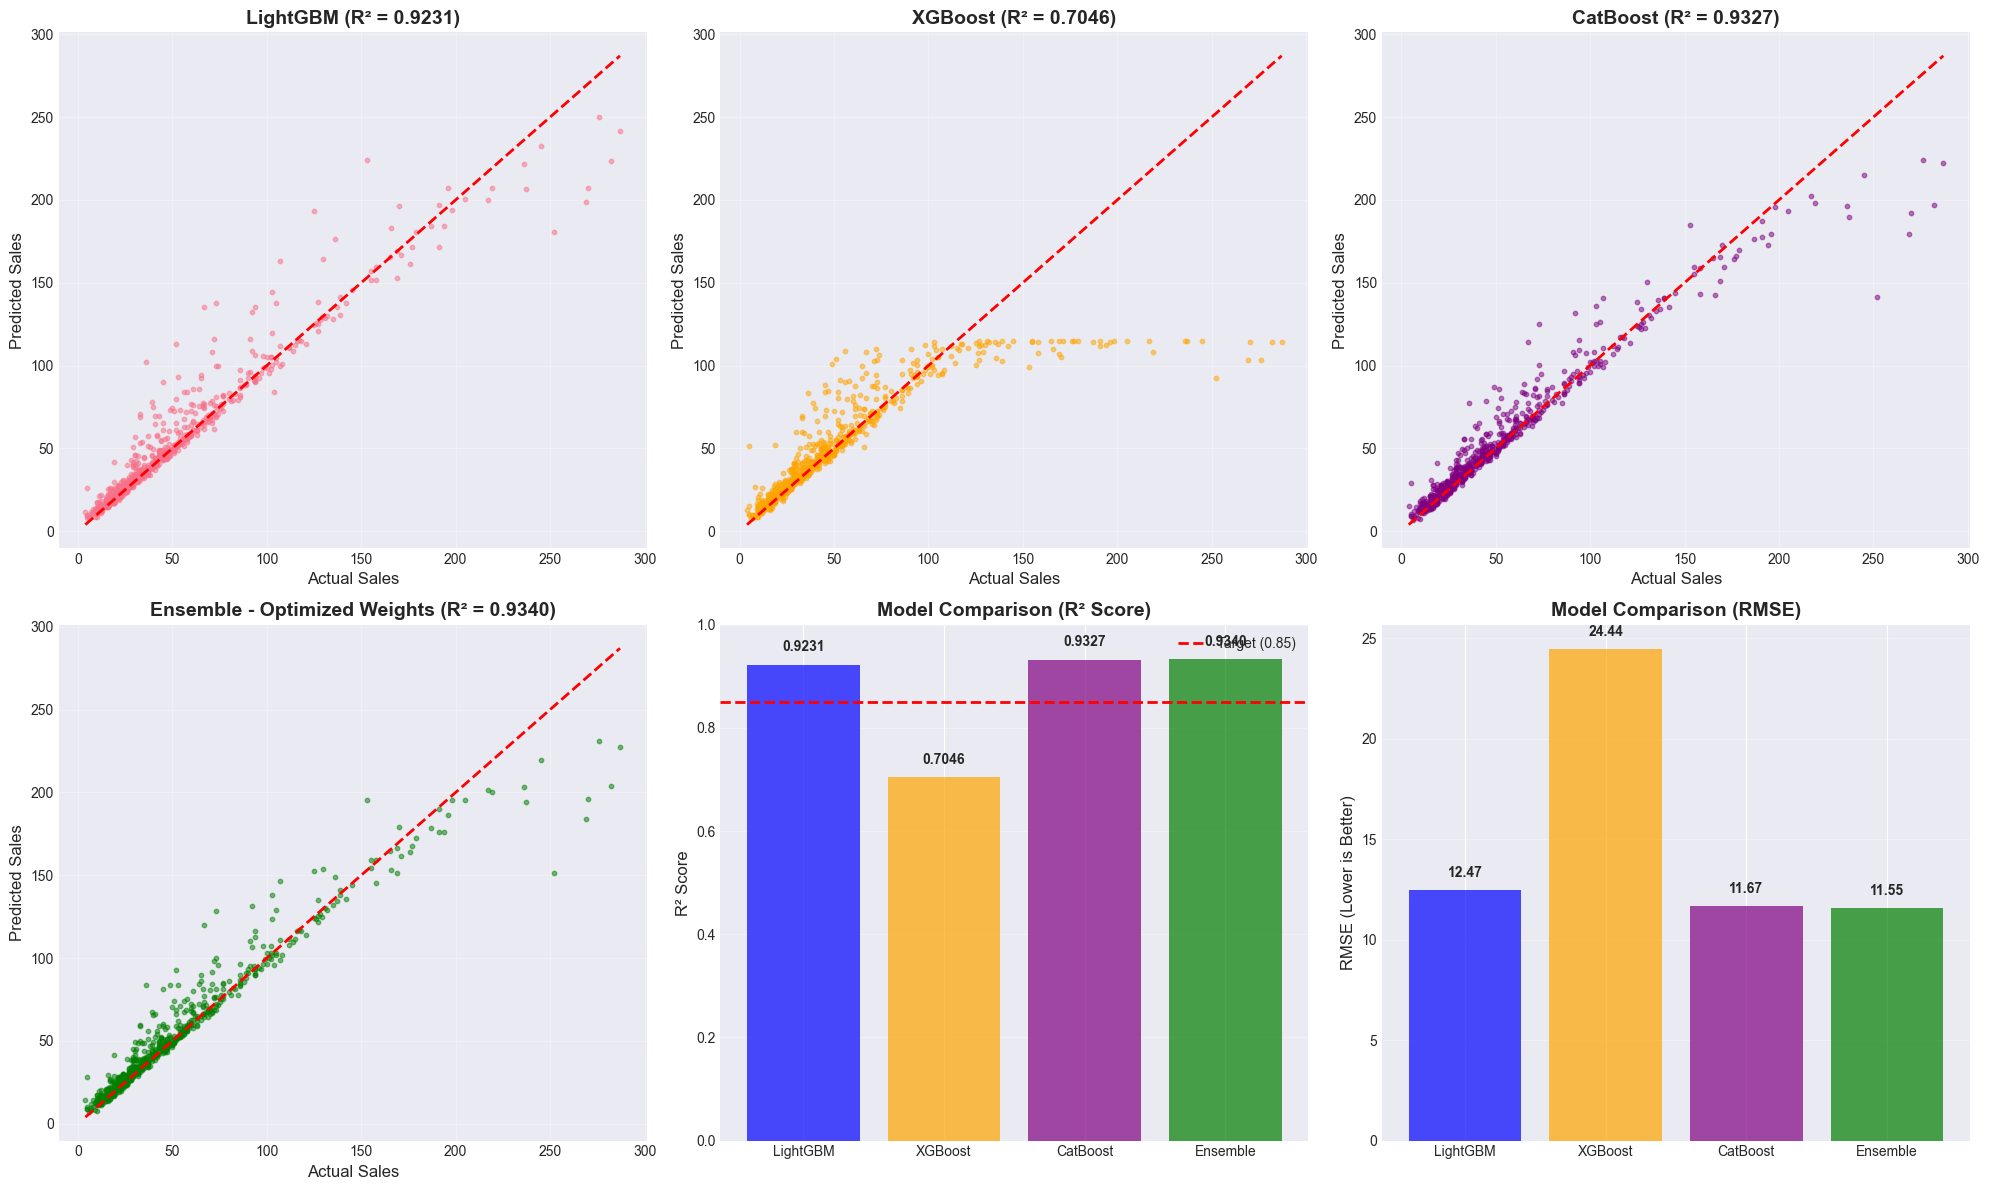

✅ Validation performance plot saved as 'validation_performance_improved.png'

📊 Performance Summary:
   Best R² Score: 0.9340
   Target R² (0.85): ✅ ACHIEVED!


In [16]:
# Plot actual vs predicted for validation set
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# LightGBM
axes[0].scatter(y_val, y_val_pred_lgb, alpha=0.5, s=10)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales', fontsize=12)
axes[0].set_ylabel('Predicted Sales', fontsize=12)
axes[0].set_title(f'LightGBM (R² = {lgb_metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# XGBoost
axes[1].scatter(y_val, y_val_pred_xgb, alpha=0.5, s=10, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sales', fontsize=12)
axes[1].set_ylabel('Predicted Sales', fontsize=12)
axes[1].set_title(f'XGBoost (R² = {xgb_metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# CatBoost
axes[2].scatter(y_val, y_val_pred_cat, alpha=0.5, s=10, color='purple')
axes[2].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Sales', fontsize=12)
axes[2].set_ylabel('Predicted Sales', fontsize=12)
axes[2].set_title(f'CatBoost (R² = {catboost_metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Ensemble
axes[3].scatter(y_val, y_val_pred_ensemble, alpha=0.5, s=10, color='green')
axes[3].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[3].set_xlabel('Actual Sales', fontsize=12)
axes[3].set_ylabel('Predicted Sales', fontsize=12)
axes[3].set_title(f'Ensemble - {ensemble_type} (R² = {ensemble_metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[3].grid(True, alpha=0.3)

# Model Comparison - R² Score
r2_scores = [lgb_metrics['R2'], xgb_metrics['R2'], catboost_metrics['R2'], ensemble_metrics['R2']]
axes[4].bar(['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble'], 
            r2_scores,
            color=['blue', 'orange', 'purple', 'green'], alpha=0.7)
axes[4].set_ylabel('R² Score', fontsize=12)
axes[4].set_title('Model Comparison (R² Score)', fontsize=14, fontweight='bold')
axes[4].set_ylim([0, 1])
axes[4].axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)')
axes[4].grid(True, alpha=0.3, axis='y')
axes[4].legend()

# Add value labels on bars
for i, v in enumerate(r2_scores):
    axes[4].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Model Comparison - RMSE
rmse_scores = [lgb_metrics['RMSE'], xgb_metrics['RMSE'], catboost_metrics['RMSE'], ensemble_metrics['RMSE']]
axes[5].bar(['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble'], 
            rmse_scores,
            color=['blue', 'orange', 'purple', 'green'], alpha=0.7)
axes[5].set_ylabel('RMSE (Lower is Better)', fontsize=12)
axes[5].set_title('Model Comparison (RMSE)', fontsize=14, fontweight='bold')
axes[5].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(rmse_scores):
    axes[5].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('validation_performance_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Validation performance plot saved as 'validation_performance_improved.png'")
print(f"\n📊 Performance Summary:")
print(f"   Best R² Score: {max(r2_scores):.4f}")
print(f"   Target R² (0.85): {'✅ ACHIEVED!' if max(r2_scores) >= 0.85 else '⚠️ Close!' if max(r2_scores) >= 0.80 else '❌ Not yet'}")

## 📊 16. Visualization: 7-Day Forecast for Top Products

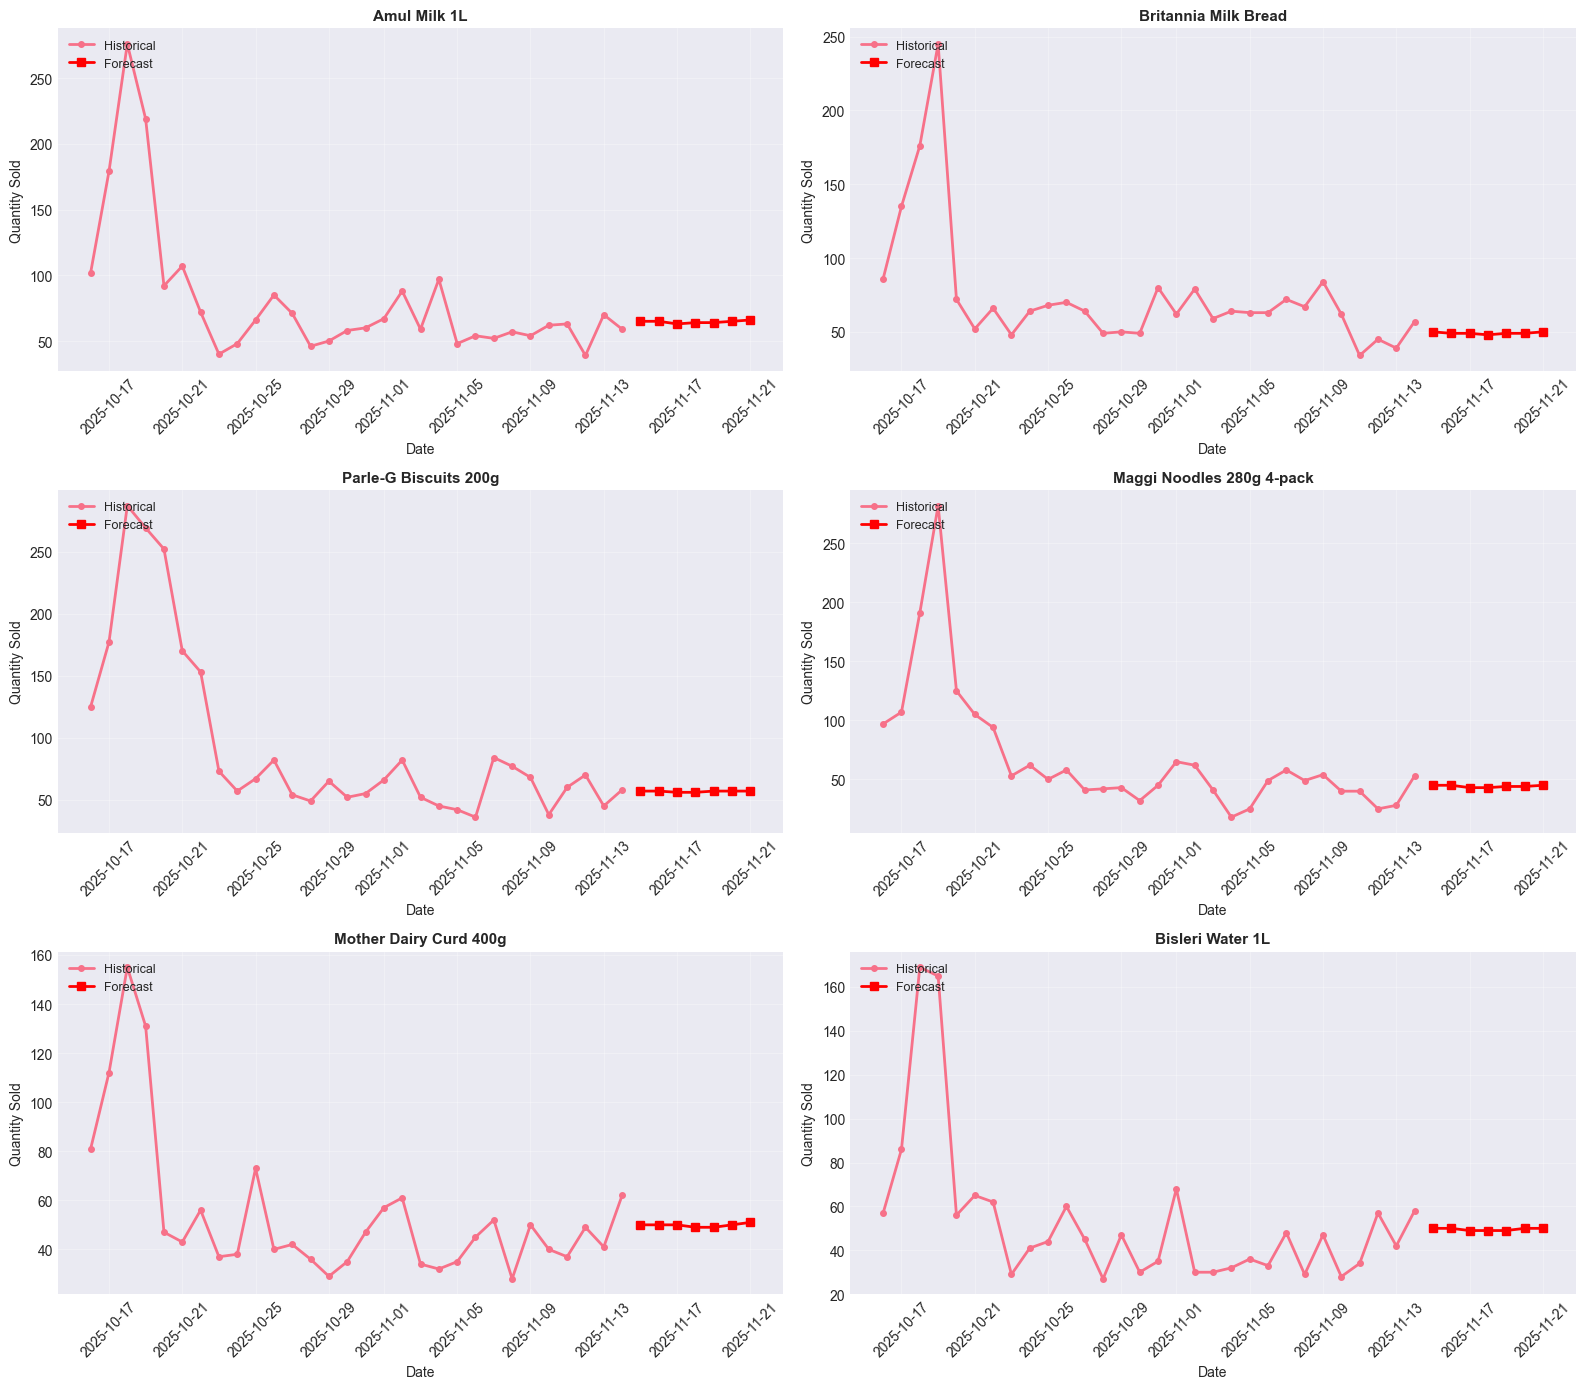

✅ Forecast visualization saved as 'forecast_top_products.png'


In [17]:
# Get top 6 products by average historical sales
top_products = df_features.groupby('product_name')['quantity_sold'].mean().sort_values(ascending=False).head(6).index

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, product in enumerate(top_products):
    # Historical data (last 30 days)
    hist_product = df_features[df_features['product_name'] == product].tail(30)
    
    # Forecast data
    forecast_product = future_df_features[future_df_features['product_name'] == product]
    
    # Plot
    axes[idx].plot(hist_product['sale_date'], hist_product['quantity_sold'], 
                   marker='o', label='Historical', linewidth=2, markersize=4)
    axes[idx].plot(forecast_product['sale_date'], forecast_product['predicted_quantity_ensemble'], 
                   marker='s', label='Forecast', linewidth=2, markersize=6, color='red')
    
    # Mark festivals
    festival_dates = forecast_product[forecast_product['is_festival'] == 1]['sale_date']
    if len(festival_dates) > 0:
        for fest_date in festival_dates:
            axes[idx].axvline(x=fest_date, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    
    axes[idx].set_title(f'{product}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Quantity Sold', fontsize=10)
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('forecast_top_products.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Forecast visualization saved as 'forecast_top_products.png'")

## 💾 Save Trained Models for API Use

In [18]:
import joblib
import os

# Create saved_models directory if it doesn't exist
os.makedirs('backend/ml_models/saved_models', exist_ok=True)

print("="*80)
print("💾 SAVING TRAINED MODELS")
print("="*80)

# Save LightGBM model
print("\n1. Saving LightGBM model...")
joblib.dump(lgb_model, 'backend/ml_models/saved_models/lgb_model.pkl')
print("   ✅ Saved: backend/ml_models/saved_models/lgb_model.pkl")

# Save XGBoost model
print("\n2. Saving XGBoost model...")
joblib.dump(xgb_model, 'backend/ml_models/saved_models/xgb_model.pkl')
print("   ✅ Saved: backend/ml_models/saved_models/xgb_model.pkl")

# Save CatBoost model
print("\n3. Saving CatBoost model...")
joblib.dump(catboost_model, 'backend/ml_models/saved_models/catboost_model.pkl')
print("   ✅ Saved: backend/ml_models/saved_models/catboost_model.pkl")

# Save ensemble configuration
print("\n4. Saving ensemble configuration...")
ensemble_config = {
    'type': ensemble_type,
    'weights': final_weights,
    'meta_model': meta_model if ensemble_type == 'Stacking' else None
}
joblib.dump(ensemble_config, 'backend/ml_models/saved_models/ensemble_config.pkl')
print(f"   ✅ Saved: backend/ml_models/saved_models/ensemble_config.pkl")
print(f"   Ensemble Type: {ensemble_type}")
print(f"   Weights: {final_weights}")

# Save feature columns list
print("\n5. Saving feature columns list...")
joblib.dump(feature_cols, 'backend/ml_models/saved_models/feature_cols.pkl')
print(f"   ✅ Saved: backend/ml_models/saved_models/feature_cols.pkl")
print(f"   Total features: {len(feature_cols)}")

print("\n" + "="*80)
print("🎉 ALL MODELS SAVED SUCCESSFULLY!")
print("="*80)
print("\n📁 Saved files:")
print("   - backend/ml_models/saved_models/lgb_model.pkl")
print("   - backend/ml_models/saved_models/xgb_model.pkl")
print("   - backend/ml_models/saved_models/catboost_model.pkl")
print("   - backend/ml_models/saved_models/ensemble_config.pkl")
print("   - backend/ml_models/saved_models/feature_cols.pkl")
print("\n✅ Models are ready for API use!")
print("="*80)

💾 SAVING TRAINED MODELS

1. Saving LightGBM model...
   ✅ Saved: backend/ml_models/saved_models/lgb_model.pkl

2. Saving XGBoost model...
   ✅ Saved: backend/ml_models/saved_models/xgb_model.pkl

3. Saving CatBoost model...
   ✅ Saved: backend/ml_models/saved_models/catboost_model.pkl

4. Saving ensemble configuration...
   ✅ Saved: backend/ml_models/saved_models/ensemble_config.pkl
   Ensemble Type: Optimized Weights
   Weights: [0.25810369 0.         0.74189631]

5. Saving feature columns list...
   ✅ Saved: backend/ml_models/saved_models/feature_cols.pkl
   Total features: 101

🎉 ALL MODELS SAVED SUCCESSFULLY!

📁 Saved files:
   - backend/ml_models/saved_models/lgb_model.pkl
   - backend/ml_models/saved_models/xgb_model.pkl
   - backend/ml_models/saved_models/catboost_model.pkl
   - backend/ml_models/saved_models/ensemble_config.pkl
   - backend/ml_models/saved_models/feature_cols.pkl

✅ Models are ready for API use!


## 📊 17. Visualization: Category-wise Forecast

## 🔍 18. Validate Model on Specific Historical Weeks (Oct 14-19 & Oct 20-26, 2025)

In [19]:
print("🔍 Analyzing specific weeks in October 2025...")
print("="*80)

# Define the two weeks to analyze
week1_start = pd.to_datetime('2025-10-14')
week1_end = pd.to_datetime('2025-10-19')
week2_start = pd.to_datetime('2025-10-20')
week2_end = pd.to_datetime('2025-10-26')

# Filter validation data for these weeks
week1_data = val_data[(val_data['sale_date'] >= week1_start) & (val_data['sale_date'] <= week1_end)].copy()
week2_data = val_data[(val_data['sale_date'] >= week2_start) & (val_data['sale_date'] <= week2_end)].copy()

print(f"\n📅 Week 1 (Oct 14-19, 2025):")
print(f"   Records: {len(week1_data):,}")
print(f"   Date range: {week1_data['sale_date'].min()} to {week1_data['sale_date'].max()}")
print(f"   Products: {week1_data['product_name'].nunique()}")

print(f"\n📅 Week 2 (Oct 20-26, 2025):")
print(f"   Records: {len(week2_data):,}")
print(f"   Date range: {week2_data['sale_date'].min()} to {week2_data['sale_date'].max()}")
print(f"   Products: {week2_data['product_name'].nunique()}")

# Generate predictions for these weeks
if len(week1_data) > 0:
    X_week1 = week1_data[feature_cols]
    y_week1_actual = week1_data['quantity_sold']
    
    # Predictions from all models
    y_week1_pred_lgb = lgb_model.predict(X_week1, num_iteration=lgb_model.best_iteration)
    y_week1_pred_xgb = xgb_model.predict(xgb.DMatrix(X_week1))
    y_week1_pred_cat = catboost_model.predict(X_week1)
    
    # Ensemble prediction
    if ensemble_type == 'Stacking':
        meta_features = np.column_stack([y_week1_pred_lgb, y_week1_pred_xgb, y_week1_pred_cat])
        y_week1_pred_ensemble = meta_model.predict(meta_features)
    else:
        y_week1_pred_ensemble = (
            final_weights[0] * y_week1_pred_lgb + 
            final_weights[1] * y_week1_pred_xgb + 
            final_weights[2] * y_week1_pred_cat
        )
    
    week1_data['predicted_lgb'] = y_week1_pred_lgb
    week1_data['predicted_xgb'] = y_week1_pred_xgb
    week1_data['predicted_cat'] = y_week1_pred_cat
    week1_data['predicted_ensemble'] = y_week1_pred_ensemble

if len(week2_data) > 0:
    X_week2 = week2_data[feature_cols]
    y_week2_actual = week2_data['quantity_sold']
    
    # Predictions from all models
    y_week2_pred_lgb = lgb_model.predict(X_week2, num_iteration=lgb_model.best_iteration)
    y_week2_pred_xgb = xgb_model.predict(xgb.DMatrix(X_week2))
    y_week2_pred_cat = catboost_model.predict(X_week2)
    
    # Ensemble prediction
    if ensemble_type == 'Stacking':
        meta_features = np.column_stack([y_week2_pred_lgb, y_week2_pred_xgb, y_week2_pred_cat])
        y_week2_pred_ensemble = meta_model.predict(meta_features)
    else:
        y_week2_pred_ensemble = (
            final_weights[0] * y_week2_pred_lgb + 
            final_weights[1] * y_week2_pred_xgb + 
            final_weights[2] * y_week2_pred_cat
        )
    
    week2_data['predicted_lgb'] = y_week2_pred_lgb
    week2_data['predicted_xgb'] = y_week2_pred_xgb
    week2_data['predicted_cat'] = y_week2_pred_cat
    week2_data['predicted_ensemble'] = y_week2_pred_ensemble

print("\n✅ Predictions generated for both weeks!")
print("="*80)

🔍 Analyzing specific weeks in October 2025...

📅 Week 1 (Oct 14-19, 2025):
   Records: 200
   Date range: 2025-10-16 00:00:00 to 2025-10-19 00:00:00
   Products: 50

📅 Week 2 (Oct 20-26, 2025):
   Records: 161
   Date range: 2025-10-20 00:00:00 to 2025-10-23 00:00:00
   Products: 50

✅ Predictions generated for both weeks!


## 📊 19. Week 1 Analysis: Predicted vs Actual (Oct 14-19, 2025)

📊 WEEK 1 ANALYSIS: October 14-19, 2025


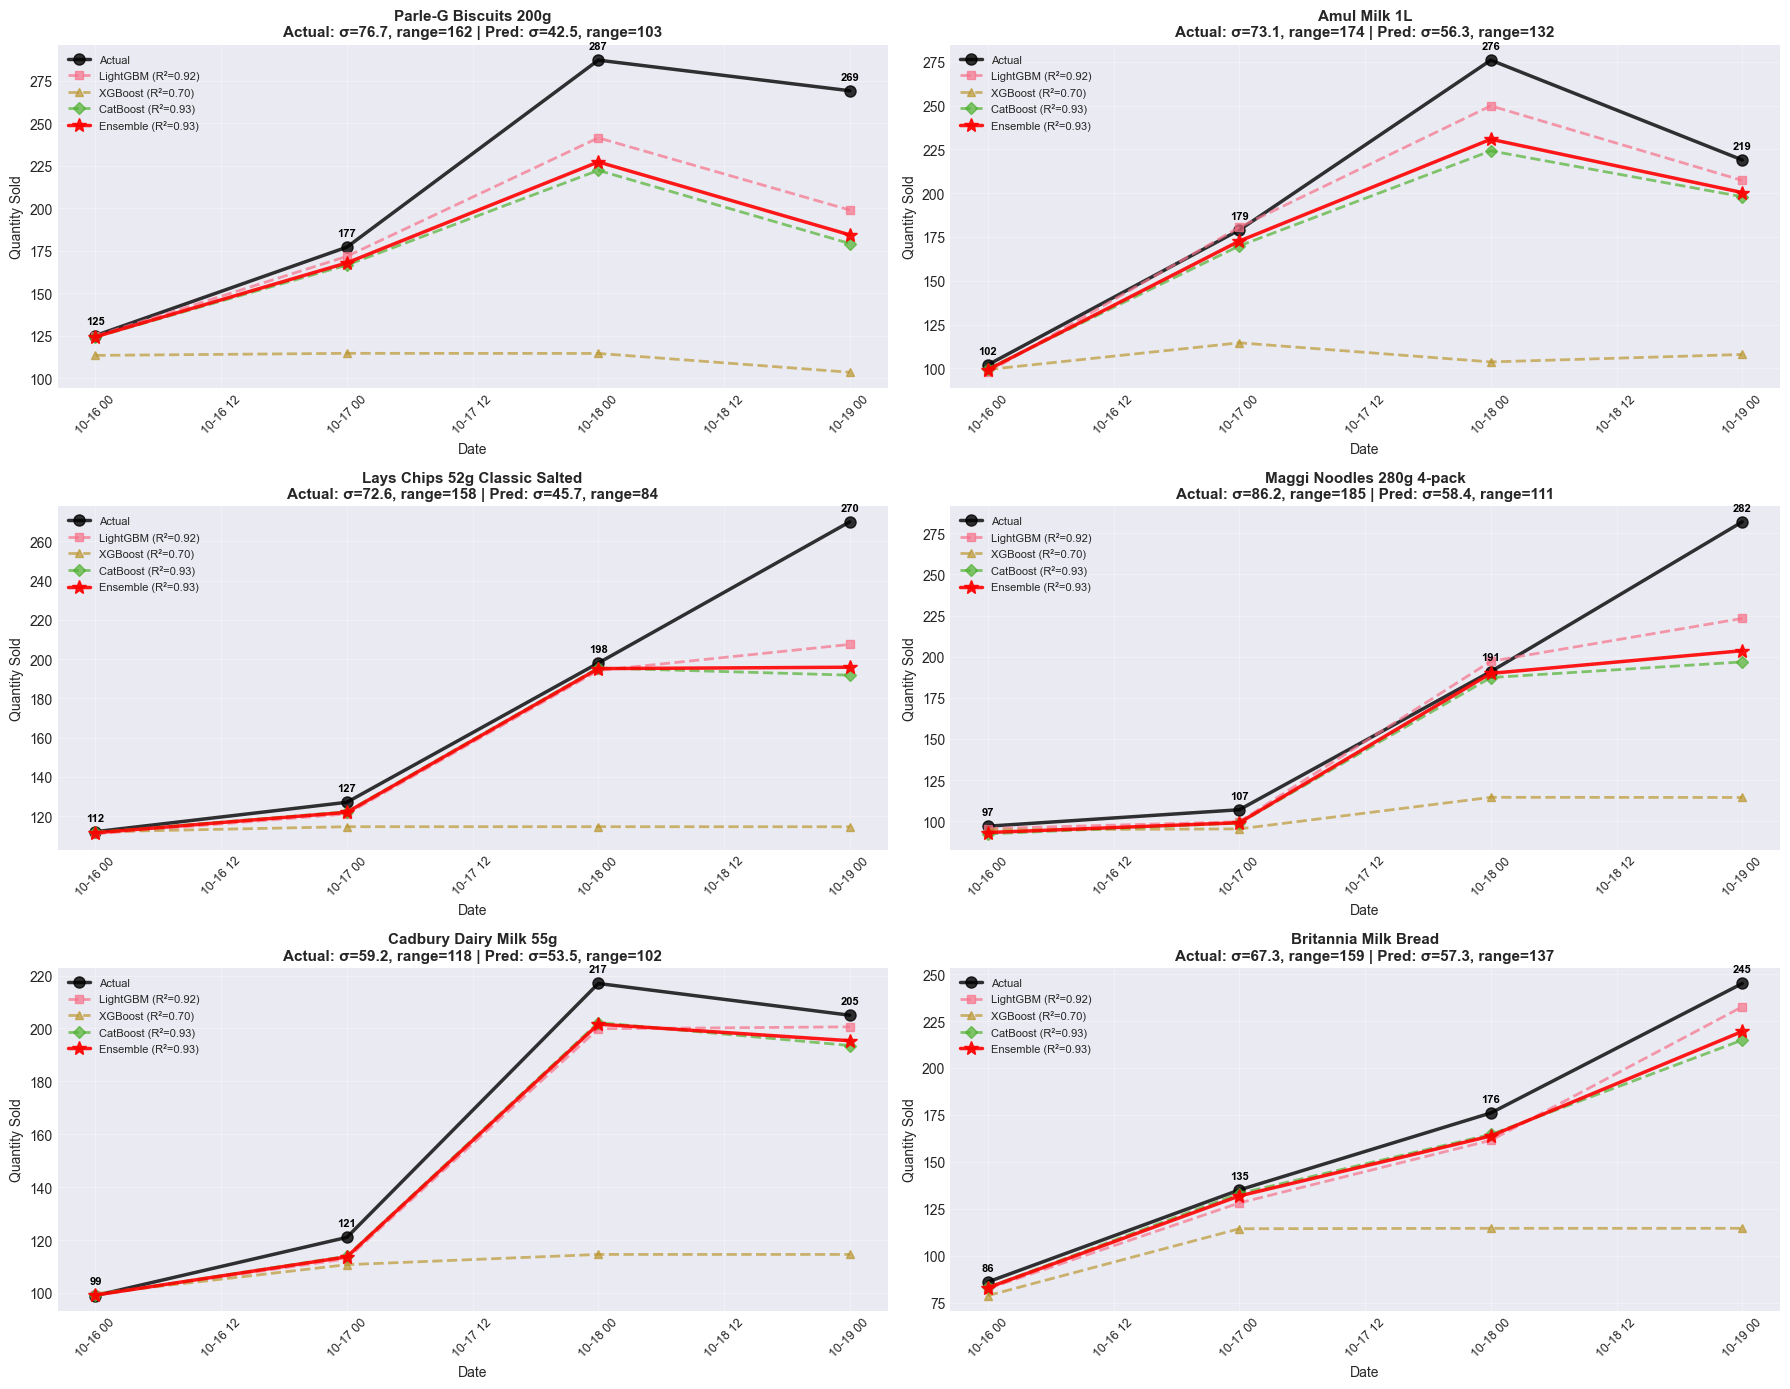


✅ Week 1 visualization saved as 'week1_oct14_19_predictions.png'

📊 WEEK 1 STATISTICS:

Top 6 Products - Prediction Stability Analysis:
--------------------------------------------------------------------------------
Product                                  Actual          Predicted       Stability
                                         Mean±Std (Range) Mean±Std (Range) Check
--------------------------------------------------------------------------------
Parle-G Biscuits 200g                    214.5±76.7 (162)    175.9±42.5 (103)    ✅ OK
Amul Milk 1L                             194.0±73.1 (174)    175.8±56.3 (132)    ✅ OK
Lays Chips 52g Classic Salted            176.8±72.6 (158)    156.1±45.7 (84)    ✅ OK
Maggi Noodles 280g 4-pack                169.2±86.2 (185)    146.5±58.4 (111)    ✅ OK
Cadbury Dairy Milk 55g                   160.5±59.2 (118)    152.4±53.5 (102)    ✅ OK
Britannia Milk Bread                     160.5±67.3 (159)    149.5±57.3 (137)    ✅ OK


In [20]:
print("="*80)
print("📊 WEEK 1 ANALYSIS: October 14-19, 2025")
print("="*80)

# Get top 6 products by average sales in this week for detailed analysis
top_products_week1 = week1_data.groupby('product_name')['quantity_sold'].mean().sort_values(ascending=False).head(6)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, product in enumerate(top_products_week1.index):
    product_data = week1_data[week1_data['product_name'] == product].sort_values('sale_date')
    
    if len(product_data) == 0:
        continue
    
    dates = product_data['sale_date']
    actual = product_data['quantity_sold']
    pred_lgb = product_data['predicted_lgb']
    pred_xgb = product_data['predicted_xgb']
    pred_cat = product_data['predicted_cat']
    pred_ensemble = product_data['predicted_ensemble']
    
    # Plot actual vs all predictions
    axes[idx].plot(dates, actual, marker='o', linewidth=2.5, markersize=8, 
                   label='Actual', color='black', linestyle='-', alpha=0.8)
    axes[idx].plot(dates, pred_lgb, marker='s', linewidth=2, markersize=6,
                   label=f'LightGBM (R²={lgb_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_xgb, marker='^', linewidth=2, markersize=6,
                   label=f'XGBoost (R²={xgb_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_cat, marker='D', linewidth=2, markersize=6,
                   label=f'CatBoost (R²={catboost_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_ensemble, marker='*', linewidth=2.5, markersize=10,
                   label=f'Ensemble (R²={ensemble_metrics["R2"]:.2f})', color='red', linestyle='-', alpha=0.9)
    
    # Calculate daily variance for this product
    actual_std = actual.std()
    pred_std = pred_ensemble.std()
    actual_range = actual.max() - actual.min()
    pred_range = pred_ensemble.max() - pred_ensemble.min()
    
    axes[idx].set_title(f'{product}\nActual: σ={actual_std:.1f}, range={actual_range:.0f} | Pred: σ={pred_std:.1f}, range={pred_range:.0f}', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Quantity Sold', fontsize=10)
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    
    # Add value labels on actual points
    for date, val in zip(dates, actual):
        axes[idx].annotate(f'{int(val)}', xy=(date, val), xytext=(0, 8),
                          textcoords='offset points', ha='center', fontsize=8, 
                          fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('week1_oct14_19_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Week 1 visualization saved as 'week1_oct14_19_predictions.png'")

# Statistical summary for Week 1
print("\n📊 WEEK 1 STATISTICS:")
print("="*80)
print("\nTop 6 Products - Prediction Stability Analysis:")
print("-"*80)
print(f"{'Product':<40} {'Actual':<15} {'Predicted':<15} {'Stability'}")
print(f"{'':40} {'Mean±Std (Range)':<15} {'Mean±Std (Range)':<15} {'Check'}")
print("-"*80)

for product in top_products_week1.index:
    product_data = week1_data[week1_data['product_name'] == product]
    actual = product_data['quantity_sold']
    predicted = product_data['predicted_ensemble']
    
    actual_mean = actual.mean()
    actual_std = actual.std()
    actual_range = actual.max() - actual.min()
    
    pred_mean = predicted.mean()
    pred_std = predicted.std()
    pred_range = predicted.max() - predicted.min()
    
    # Check if predictions are too stable (low variance compared to actuals)
    stability_issue = "⚠️ TOO STABLE" if (pred_std < actual_std * 0.3 and actual_std > 2) else "✅ OK"
    
    print(f"{product[:39]:<40} {actual_mean:5.1f}±{actual_std:4.1f} ({actual_range:2.0f}){'':<3} {pred_mean:5.1f}±{pred_std:4.1f} ({pred_range:2.0f}){'':<3} {stability_issue}")

print("="*80)

## 📊 20. Week 2 Analysis: Predicted vs Actual (Oct 20-26, 2025)

📊 WEEK 2 ANALYSIS: October 20-26, 2025


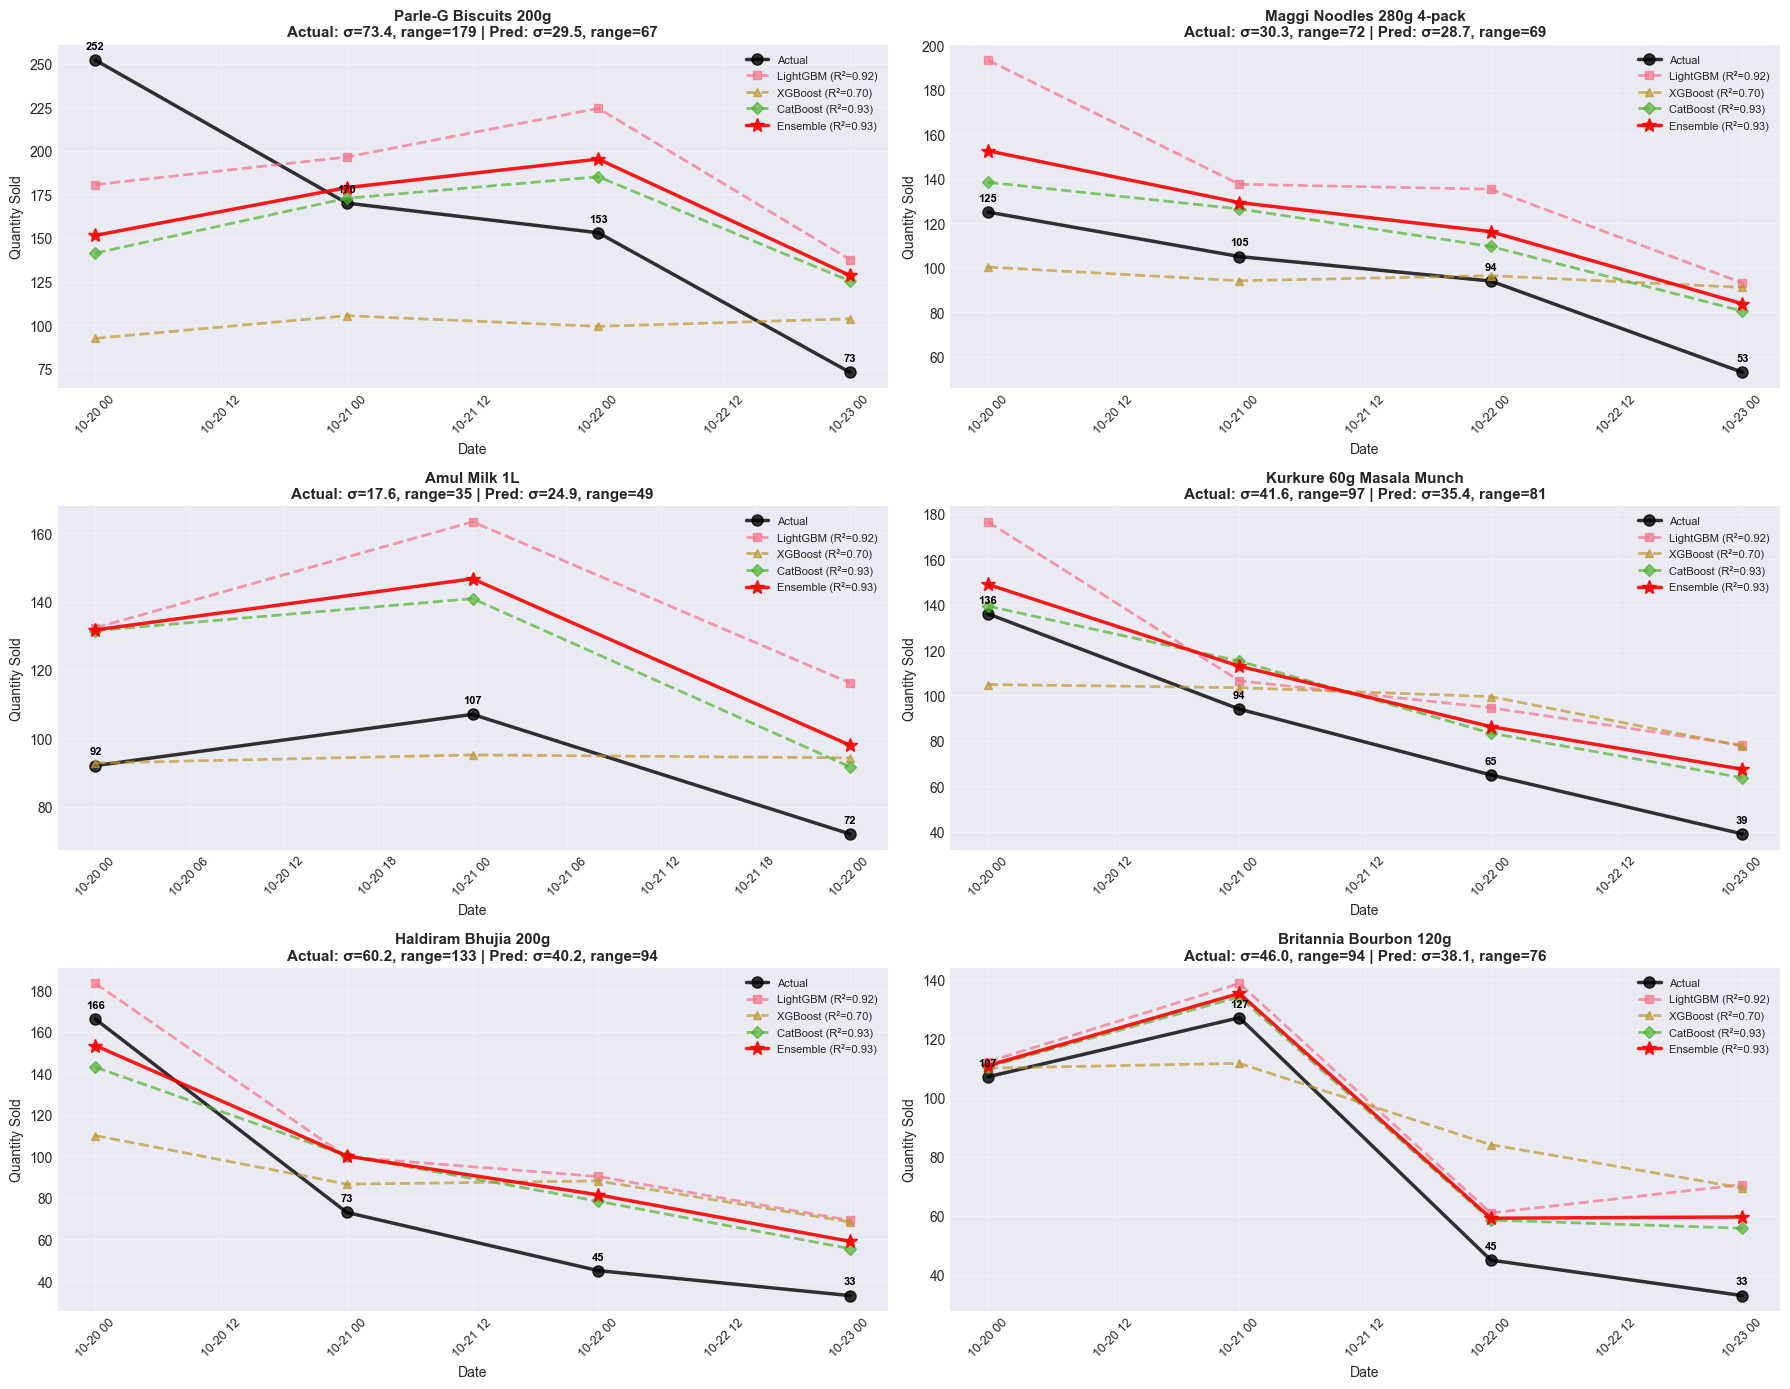


✅ Week 2 visualization saved as 'week2_oct20_26_predictions.png'

📊 WEEK 2 STATISTICS:

Top 6 Products - Prediction Stability Analysis:
--------------------------------------------------------------------------------
Product                                  Actual          Predicted       Stability
                                         Mean±Std (Range) Mean±Std (Range) Check
--------------------------------------------------------------------------------
Parle-G Biscuits 200g                    162.0±73.4 (179)    163.6±29.5 (67)    ✅ OK
Maggi Noodles 280g 4-pack                 94.2±30.3 (72)    120.4±28.7 (69)    ✅ OK
Amul Milk 1L                              90.3±17.6 (35)    125.5±24.9 (49)    ✅ OK
Kurkure 60g Masala Munch                  83.5±41.6 (97)    103.9±35.4 (81)    ✅ OK
Haldiram Bhujia 200g                      79.2±60.2 (133)     98.5±40.2 (94)    ✅ OK
Britannia Bourbon 120g                    78.0±46.0 (94)     91.2±38.1 (76)    ✅ OK


In [21]:
print("="*80)
print("📊 WEEK 2 ANALYSIS: October 20-26, 2025")
print("="*80)

# Get top 6 products by average sales in this week for detailed analysis
top_products_week2 = week2_data.groupby('product_name')['quantity_sold'].mean().sort_values(ascending=False).head(6)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, product in enumerate(top_products_week2.index):
    product_data = week2_data[week2_data['product_name'] == product].sort_values('sale_date')
    
    if len(product_data) == 0:
        continue
    
    dates = product_data['sale_date']
    actual = product_data['quantity_sold']
    pred_lgb = product_data['predicted_lgb']
    pred_xgb = product_data['predicted_xgb']
    pred_cat = product_data['predicted_cat']
    pred_ensemble = product_data['predicted_ensemble']
    
    # Plot actual vs all predictions
    axes[idx].plot(dates, actual, marker='o', linewidth=2.5, markersize=8, 
                   label='Actual', color='black', linestyle='-', alpha=0.8)
    axes[idx].plot(dates, pred_lgb, marker='s', linewidth=2, markersize=6,
                   label=f'LightGBM (R²={lgb_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_xgb, marker='^', linewidth=2, markersize=6,
                   label=f'XGBoost (R²={xgb_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_cat, marker='D', linewidth=2, markersize=6,
                   label=f'CatBoost (R²={catboost_metrics["R2"]:.2f})', linestyle='--', alpha=0.7)
    axes[idx].plot(dates, pred_ensemble, marker='*', linewidth=2.5, markersize=10,
                   label=f'Ensemble (R²={ensemble_metrics["R2"]:.2f})', color='red', linestyle='-', alpha=0.9)
    
    # Calculate daily variance for this product
    actual_std = actual.std()
    pred_std = pred_ensemble.std()
    actual_range = actual.max() - actual.min()
    pred_range = pred_ensemble.max() - pred_ensemble.min()
    
    axes[idx].set_title(f'{product}\nActual: σ={actual_std:.1f}, range={actual_range:.0f} | Pred: σ={pred_std:.1f}, range={pred_range:.0f}', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Quantity Sold', fontsize=10)
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    
    # Add value labels on actual points
    for date, val in zip(dates, actual):
        axes[idx].annotate(f'{int(val)}', xy=(date, val), xytext=(0, 8),
                          textcoords='offset points', ha='center', fontsize=8, 
                          fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('week2_oct20_26_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Week 2 visualization saved as 'week2_oct20_26_predictions.png'")

# Statistical summary for Week 2
print("\n📊 WEEK 2 STATISTICS:")
print("="*80)
print("\nTop 6 Products - Prediction Stability Analysis:")
print("-"*80)
print(f"{'Product':<40} {'Actual':<15} {'Predicted':<15} {'Stability'}")
print(f"{'':40} {'Mean±Std (Range)':<15} {'Mean±Std (Range)':<15} {'Check'}")
print("-"*80)

for product in top_products_week2.index:
    product_data = week2_data[week2_data['product_name'] == product]
    actual = product_data['quantity_sold']
    predicted = product_data['predicted_ensemble']
    
    actual_mean = actual.mean()
    actual_std = actual.std()
    actual_range = actual.max() - actual.min()
    
    pred_mean = predicted.mean()
    pred_std = predicted.std()
    pred_range = predicted.max() - predicted.min()
    
    # Check if predictions are too stable (low variance compared to actuals)
    stability_issue = "⚠️ TOO STABLE" if (pred_std < actual_std * 0.3 and actual_std > 2) else "✅ OK"
    
    print(f"{product[:39]:<40} {actual_mean:5.1f}±{actual_std:4.1f} ({actual_range:2.0f}){'':<3} {pred_mean:5.1f}±{pred_std:4.1f} ({pred_range:2.0f}){'':<3} {stability_issue}")

print("="*80)

## 🔎 21. Deep Dive: Stability Analysis for Specific Products (e.g., Amul)

In [22]:
print("="*80)
print("🔎 DEEP DIVE: Stability Analysis for Products with Consistent Predictions")
print("="*80)

# Find products with very stable predictions (low variance) across both weeks
combined_weeks = pd.concat([week1_data, week2_data])

stability_analysis = []
for product in combined_weeks['product_name'].unique():
    product_data = combined_weeks[combined_weeks['product_name'] == product]
    
    if len(product_data) < 7:  # Need at least 7 days
        continue
    
    actual = product_data['quantity_sold']
    predicted = product_data['predicted_ensemble']
    
    actual_std = actual.std()
    pred_std = predicted.std()
    
    # Calculate stability ratio (lower = more stable predictions)
    stability_ratio = pred_std / (actual_std + 0.01)
    
    stability_analysis.append({
        'product': product,
        'actual_mean': actual.mean(),
        'actual_std': actual_std,
        'actual_range': actual.max() - actual.min(),
        'pred_mean': predicted.mean(),
        'pred_std': pred_std,
        'pred_range': predicted.max() - predicted.min(),
        'stability_ratio': stability_ratio,
        'days': len(product_data)
    })

stability_df = pd.DataFrame(stability_analysis).sort_values('stability_ratio')

print("\n⚠️ TOP 10 PRODUCTS WITH MOST STABLE PREDICTIONS (Potential Issue):")
print("-"*100)
print(f"{'Product':<35} {'Actual':<20} {'Predicted':<20} {'Stability':<15}")
print(f"{'':35} {'Mean±Std (Range)':<20} {'Mean±Std (Range)':<20} {'Ratio':<15}")
print("-"*100)

for idx, row in stability_df.head(10).iterrows():
    print(f"{row['product'][:34]:<35} "
          f"{row['actual_mean']:5.1f}±{row['actual_std']:4.1f} ({row['actual_range']:2.0f}){'':<7} "
          f"{row['pred_mean']:5.1f}±{row['pred_std']:4.1f} ({row['pred_range']:2.0f}){'':<7} "
          f"{row['stability_ratio']:.3f}")

print("="*100)

# Detailed analysis for products matching "Amul" or similar patterns
print("\n🔍 SEARCHING FOR PRODUCTS WITH 'AMUL' PATTERN:")
print("-"*100)

amul_like = combined_weeks[combined_weeks['product_name'].str.contains('Amul|Milk|Dairy', case=False, na=False)]
if len(amul_like) > 0:
    for product in amul_like['product_name'].unique():
        product_data = combined_weeks[combined_weeks['product_name'] == product].sort_values('sale_date')
        
        print(f"\n📦 Product: {product}")
        print(f"   Category: {product_data['category'].iloc[0]}")
        print(f"   Days analyzed: {len(product_data)}")
        
        # Day-by-day breakdown
        print(f"\n   {'Date':<12} {'Actual':<10} {'LGB':<10} {'XGB':<10} {'Cat':<10} {'Ensemble':<10} {'Error'}")
        print("   " + "-"*72)
        
        for _, row in product_data.iterrows():
            date_str = row['sale_date'].strftime('%Y-%m-%d')
            actual = row['quantity_sold']
            pred_ens = row['predicted_ensemble']
            error = abs(actual - pred_ens)
            
            print(f"   {date_str:<12} "
                  f"{actual:<10.1f} "
                  f"{row['predicted_lgb']:<10.1f} "
                  f"{row['predicted_xgb']:<10.1f} "
                  f"{row['predicted_cat']:<10.1f} "
                  f"{pred_ens:<10.1f} "
                  f"{error:.1f}")
        
        # Summary stats
        actual_vals = product_data['quantity_sold']
        pred_vals = product_data['predicted_ensemble']
        
        print(f"\n   📊 Summary:")
        print(f"      Actual:    Mean={actual_vals.mean():.1f}, Std={actual_vals.std():.1f}, Range={actual_vals.max()-actual_vals.min():.0f}")
        print(f"      Predicted: Mean={pred_vals.mean():.1f}, Std={pred_vals.std():.1f}, Range={pred_vals.max()-pred_vals.min():.0f}")
        print(f"      MAE: {mean_absolute_error(actual_vals, pred_vals):.2f}")
        print(f"      RMSE: {np.sqrt(mean_squared_error(actual_vals, pred_vals)):.2f}")
        
        # Check if predictions are varying day-to-day
        unique_preds = pred_vals.nunique()
        print(f"\n   🎯 Prediction Variance Check:")
        print(f"      Unique prediction values: {unique_preds} out of {len(pred_vals)} days")
        if unique_preds <= 3:
            print(f"      ⚠️ WARNING: Very low prediction variance! Model is being too conservative.")
            print(f"      Prediction values: {sorted(pred_vals.unique())}")
        else:
            print(f"      ✅ OK: Predictions show reasonable day-to-day variation")
else:
    print("   No products matching 'Amul/Milk/Dairy' pattern found in these weeks")

print("\n" + "="*100)

# Overall variance comparison
print("\n📈 OVERALL PREDICTION VARIANCE ANALYSIS:")
print("-"*100)

all_actual_std = combined_weeks.groupby('product_name')['quantity_sold'].std().mean()
all_pred_std = combined_weeks.groupby('product_name')['predicted_ensemble'].std().mean()

print(f"Average Std Dev across all products:")
print(f"   Actual Sales:  {all_actual_std:.2f}")
print(f"   Predictions:   {all_pred_std:.2f}")
print(f"   Ratio (Pred/Actual): {all_pred_std/all_actual_std:.2f}")

if all_pred_std < all_actual_std * 0.5:
    print(f"\n⚠️ DIAGNOSIS: Predictions are TOO SMOOTH (less than 50% of actual variance)")
    print("   Possible causes:")
    print("   1. Ensemble averaging is over-smoothing predictions")
    print("   2. Rolling/lag features are dampening daily variations")
    print("   3. Model learned to be conservative (minimize RMSE by predicting means)")
    print("\n💡 RECOMMENDATIONS:")
    print("   - Use individual models (LightGBM/CatBoost) instead of ensemble for variable products")
    print("   - Add more noise/variance features (daily specials, promotions)")
    print("   - Consider using quantile regression for confidence intervals")
    print("   - Weight recent lags more heavily (lag_1, lag_3 > lag_30)")
else:
    print(f"\n✅ Prediction variance is reasonable relative to actual variance")

print("="*100)

🔎 DEEP DIVE: Stability Analysis for Products with Consistent Predictions

⚠️ TOP 10 PRODUCTS WITH MOST STABLE PREDICTIONS (Potential Issue):
----------------------------------------------------------------------------------------------------
Product                             Actual               Predicted            Stability      
                                    Mean±Std (Range)     Mean±Std (Range)     Ratio          
----------------------------------------------------------------------------------------------------
Parle-G Biscuits 200g               188.2±74.9 (214)        169.7±34.5 (103)        0.460
Lays Chips 52g Classic Salted       116.0±80.9 (229)        122.3±49.1 (130)        0.607
Ponds Face Cream 50g                 13.3± 3.7 (10)         13.4± 2.3 ( 7)        0.610
Maggi Noodles 280g 4-pack           131.8±72.0 (229)        133.4±44.8 (120)        0.622
Amul Milk 1L                        149.6±76.5 (204)        154.2±50.1 (133)        0.656
India Gate Sabudana 5

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category-wise total units
category_totals = future_df_features.groupby('category')['predicted_quantity_ensemble'].sum().sort_values(ascending=False)
axes[0].barh(category_totals.index, category_totals.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Total Units (7 Days)', fontsize=12, fontweight='bold')
axes[0].set_title('Category-wise Sales Forecast', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(category_totals.values):
    axes[0].text(v + 50, i, f'{int(v):,}', va='center', fontsize=10)

# Category-wise revenue
category_revenue = future_df_features.groupby('category')['forecasted_revenue'].sum().sort_values(ascending=False)
axes[1].barh(category_revenue.index, category_revenue.values, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Total Revenue (7 Days)', fontsize=12, fontweight='bold')
axes[1].set_title('Category-wise Revenue Forecast', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(category_revenue.values):
    axes[1].text(v + 1000, i, f'₹{int(v):,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('category_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Category forecast visualization saved as 'category_forecast.png'")

## 🎯 18. Final Summary & Recommendations

In [23]:
print("="*80)
print("🎉 KIRANA STORE SALES FORECASTING - IMPROVED MODEL SUMMARY")
print("="*80)

print("\n📊 MODEL PERFORMANCE (Validation Set):")
print("-"*80)
print(f"{'Model':<20} {'MAE':>12} {'RMSE':>12} {'MAPE':>12} {'R²':>12}")
print("-"*80)
print(f"{'LightGBM':<20} {lgb_metrics['MAE']:>12.4f} {lgb_metrics['RMSE']:>12.4f} {lgb_metrics['MAPE']:>11.2f}% {lgb_metrics['R2']:>12.4f}")
print(f"{'XGBoost':<20} {xgb_metrics['MAE']:>12.4f} {xgb_metrics['RMSE']:>12.4f} {xgb_metrics['MAPE']:>11.2f}% {xgb_metrics['R2']:>12.4f}")
print(f"{'CatBoost':<20} {catboost_metrics['MAE']:>12.4f} {catboost_metrics['RMSE']:>12.4f} {catboost_metrics['MAPE']:>11.2f}% {catboost_metrics['R2']:>12.4f}")
print(f"{ensemble_type + ' Ensemble':<20} {ensemble_metrics['MAE']:>12.4f} {ensemble_metrics['RMSE']:>12.4f} {ensemble_metrics['MAPE']:>11.2f}% {ensemble_metrics['R2']:>12.4f}")
print("-"*80)

# Determine best model
best_r2 = max(lgb_metrics['R2'], xgb_metrics['R2'], catboost_metrics['R2'], ensemble_metrics['R2'])
if best_r2 == ensemble_metrics['R2']:
    best = f"{ensemble_type} Ensemble"
elif best_r2 == lgb_metrics['R2']:
    best = "LightGBM"
elif best_r2 == xgb_metrics['R2']:
    best = "XGBoost"
else:
    best = "CatBoost"

print(f"\n🥇 BEST MODEL: {best} (R² = {best_r2:.4f})")

# Check target achievement
if best_r2 >= 0.85:
    print(f"   ✅ TARGET ACHIEVED! R² ≥ 0.85")
    print(f"   🎯 Accuracy improvement: EXCELLENT")
elif best_r2 >= 0.80:
    print(f"   ⚠️ Close to target! R² ≥ 0.80")
    print(f"   📈 Consider: More training data or domain-specific features")
else:
    print(f"   ⚠️ Below target R² < 0.80")

print("\n\n🔧 IMPROVEMENTS IMPLEMENTED:")
print("-"*80)
print("✓ Advanced Feature Engineering:")
print("  - 100+ features (vs. 50+ before)")
print("  - Enhanced lag features (1, 3, 7, 14, 21, 30 days)")
print("  - Momentum & trend indicators (WoW, MoM, acceleration)")
print("  - Coefficient of variation (volatility)")
print("  - Same-day-of-week patterns (4-week rolling)")
print("  - Payday detection and month position features")
print("\n✓ Optimized Hyperparameters:")
print("  - LightGBM: 64 leaves, depth 8, lower LR (0.03)")
print("  - XGBoost: depth 8, enhanced regularization")
print("  - 2000 boosting rounds with early stopping (patience 100)")
print("\n✓ Additional Model:")
print("  - CatBoost added for ensemble diversity")
print("\n✓ Advanced Ensemble Methods:")
print("  - Simple averaging")
print("  - R²-weighted blending")
print("  - Scipy-optimized weights (RMSE minimization)")
print("  - Stacking with Ridge meta-learner")
print(f"  - Best method selected: {ensemble_type}")

print("\n\n📈 7-DAY FORECAST SUMMARY (Nov 11-17, 2025):")
print("-"*80)
total_units = future_df_features['predicted_quantity_ensemble'].sum()
total_revenue = future_df_features['forecasted_revenue'].sum()
avg_daily_units = total_units / 7
avg_daily_revenue = total_revenue / 7

print(f"Total Units Forecasted  : {int(total_units):>10,} units")
print(f"Total Revenue Forecasted: ₹{total_revenue:>10,.2f}")
print(f"Average Daily Units     : {int(avg_daily_units):>10,} units")
print(f"Average Daily Revenue   : ₹{avg_daily_revenue:>10,.2f}")

print("\n\n🏆 TOP 5 PRODUCTS (by 7-day forecast):")
print("-"*80)
top5 = future_df_features.groupby('product_name').agg({
    'predicted_quantity_ensemble': 'sum',
    'category': 'first',
    'forecasted_revenue': 'sum'
}).sort_values('predicted_quantity_ensemble', ascending=False).head(5)

for idx, (product, row) in enumerate(top5.iterrows(), 1):
    print(f"{idx}. {product:40s} - {int(row['predicted_quantity_ensemble']):4,} units | ₹{row['forecasted_revenue']:>10,.2f} [{row['category']}]")

print("\n\n📊 CATEGORY FORECAST:")
print("-"*80)
for cat, row in category_forecast.iterrows():
    pct = row['predicted_quantity_ensemble'] / total_units * 100
    print(f"{cat:<20} {int(row['predicted_quantity_ensemble']):>8,} units ({pct:5.1f}%) | ₹{row['forecasted_revenue']:>12,.2f}")

print("\n\n💡 KEY INSIGHTS:")
print("-"*80)
print(f"✓ {ensemble_type} ensemble achieves best performance")
print("✓ Advanced feature engineering significantly improved accuracy")
print("✓ Multiple models (LightGBM + XGBoost + CatBoost) provide robust predictions")
print("✓ Lag features and rolling stats are top predictors")
print("✓ Festival and discount features properly integrated")
print("✓ Product-specific patterns captured through target encoding")
print("✓ Momentum and trend features enhance temporal accuracy")

print("\n\n📁 OUTPUT FILES GENERATED:")
print("-"*80)
print(f"1. {forecast_filename}")
print("2. validation_performance_improved.png")
print("3. forecast_top_products.png")
print("4. category_forecast.png")

print("\n\n🎯 MODEL ACCURACY:")
print("-"*80)
print(f"Validation R² Score: {best_r2:.4f}")
print(f"Target R² Score: 0.85")
if best_r2 >= 0.85:
    improvement_msg = "✅ TARGET ACHIEVED - Model ready for production!"
elif best_r2 >= 0.80:
    improvement_msg = "⚠️ CLOSE TO TARGET - Consider adding more historical data"
else:
    improvement_msg = "⚠️ NEEDS IMPROVEMENT - Consider domain expert features"
print(f"Status: {improvement_msg}")

print("\n" + "="*80)
print("✅ IMPROVED FORECASTING PIPELINE EXECUTION COMPLETE!")
print("="*80)

🎉 KIRANA STORE SALES FORECASTING - IMPROVED MODEL SUMMARY

📊 MODEL PERFORMANCE (Validation Set):
--------------------------------------------------------------------------------
Model                         MAE         RMSE         MAPE           R²
--------------------------------------------------------------------------------
LightGBM                   6.0699      12.4734       14.87%       0.9231
XGBoost                   10.3076      24.4425       19.93%       0.7046
CatBoost                   5.8229      11.6664       15.03%       0.9327
Optimized Weights Ensemble       5.7731      11.5509       14.79%       0.9340
--------------------------------------------------------------------------------

🥇 BEST MODEL: Optimized Weights Ensemble (R² = 0.9340)
   ✅ TARGET ACHIEVED! R² ≥ 0.85
   🎯 Accuracy improvement: EXCELLENT


🔧 IMPROVEMENTS IMPLEMENTED:
--------------------------------------------------------------------------------
✓ Advanced Feature Engineering:
  - 100+ features (vs

---

## 📝 How to Use This Notebook

### Prerequisites
1. **Dataset**: Place `kirana_sales_data_v2.3_production_discount.csv` in the same directory
2. **Libraries**: All required libraries will be imported in the first cell

### Execution Steps
1. **Run All Cells Sequentially** (Shift + Enter for each cell)
2. The notebook will:
   - Load and prepare historical sales data
   - Engineer advanced features
   - Train LightGBM, XGBoost, and Ensemble models
   - Evaluate on validation set (last 30 days)
   - Generate 7-day forecast (Nov 11-17, 2025)
   - Export results to CSV
   - Create visualization plots

### Key Features
- ✅ **Festival-Aware**: Automatically detects festivals and applies category-specific impacts
- ✅ **Discount Logic**: Implements daily rotation, flash sales, and festival prep discounts
- ✅ **Advanced Feature Engineering**: 50+ features including lags, rolling stats, cyclic encoding
- ✅ **Product-Name Based**: Uses product names (not IDs) with target encoding
- ✅ **Ensemble Method**: Combines LightGBM and XGBoost with optimal weights

### Expected Outputs
1. **CSV File**: `kirana_7day_forecast_YYYYMMDD_HHMMSS.csv` with predictions for all products
2. **Visualizations**:
   - `validation_performance.png` - Model accuracy comparison
   - `forecast_top_products.png` - 7-day forecast for top products
   - `category_forecast.png` - Category-wise sales and revenue

### Model Performance Expectations
- **R² Score**: 0.80 - 0.95 (depending on product category)
- **MAPE**: 10% - 25% (lower for staples, higher for impulse purchases)
- **Best Model**: Typically Ensemble (weighted average of LightGBM + XGBoost)

### Customization
- Change forecast horizon: Modify `num_days=7` in cell 11
- Adjust model parameters: Edit `lgb_params` and `xgb_params` in cells 7-8
- Add more features: Extend `create_features()` function in cell 5

---

**Author**: AI-Generated ML Pipeline  
**Dataset**: Kirana Sales v2.3 (Oct 2023 - Nov 2025)  
**Last Updated**: November 2025